---

title: **Interpolation Comparison** 

**Methods**:

- 1. [Shape-based interpolation](https://www.researchgate.net/publication/221400411_Efficient_Semiautomatic_Segmentation_of_3D_Objects_in_Medical_Images) inspired by Schenk *et al*.

- 2. [*Pyspatiotemporalgeom*](https://dl.acm.org/doi/10.1145/2996913.2996973) library based interpolation 

- 3. Conditional CNN-VAE interpolation

---

In [1]:
from watermark import watermark
print(watermark(author="\033[1m" +"Tiago F. R. Ribeiro" + "\033[0m", 
                github_username="\033[1m" +"Tiago1Ribeiro"+ "\033[0m", 
                current_date=True, current_time=True, python=True, updated=True,
                iversions=True,  globals_= globals()))

Author: Tiago F. R. Ribeiro

Github username: Tiago1Ribeiro

Last updated: 2023-06-14 09:05:00

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.11.0



### Libraries

In [3]:
import os
os.environ['USE_PYGEOS'] = '0'      # to avoid a bug in geopandas
import cv2                                          
import numpy as np                                                  
import math                                         
from glob import glob                              
from PIL import Image                              
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])
plt.style.use(['nature','no-latex'])
from shapely import wkt              
from shapely.geometry import Polygon, MultiPolygon, shape
from shapely.affinity import scale
from rasterio.features import shapes  
from rasterio import Affine           
from shapely.wkt import loads
from shapely import hausdorff_distance
# from shapely.geometry.base import geom_factory
# from shapely.geos import lgeos
from shapely.validation import make_valid
import geopandas as gpd

### Data sources

In [37]:
DIR = os.getcwd()
# Reference U-Net Based Segmentations
UNET_DIR = os.path.join("E:\BurnedAreaUAV_files\BurnedAreaUAV_dataset\Results")
UNET_PNG_DIR = os.path.join(UNET_DIR, "segs_base")
UNET_WKT_FILE = os.path.join(UNET_DIR, "WKT_files\segs_unet_base_new.wkt")
# Test Segmentation from BurnedAreaUAV dataset
BA_UAV_DIR = os.path.normpath("E://BurnedAreaUAV_files//BurnedAreaUAV_dataset")
BA_UAV_WKT = os.path.join(BA_UAV_DIR, "BurnedAreaUAV_dataset//WKT//test.wkt")
# Interpolation Directory
INTERPOL_DIR = os.path.normpath("E://BurnedAreaUAV_files//Interpolation")
# Sampled Masks
SAMPLED_MASKS = os.path.join(INTERPOL_DIR, "reference_masks//sampled_masks.txt")
# Shape Based Interpolations
SHP_DIR = os.path.join(INTERPOL_DIR, "shape_interpol")
SHP_PNG_DIR = os.path.join(SHP_DIR, "PNGs")
SHP_PNG_DIR_SAMPLED = os.path.join(SHP_DIR, "PNGs_sampled")
SHP_WKT_FILE = os.path.join(SHP_DIR, "shape_interpol.wkt")
SHP_WKT_FILE_SAMPLED = os.path.join(SHP_DIR, "shape_interpol_sampled.wkt")
# Pyspatiotemporalgeom interpolations
PSTG_DIR = os.path.join(INTERPOL_DIR, "pyspatiotemporalgeom_interpol")
PSTG_PNG_DIR = os.path.join(PSTG_DIR, "PNGs")
PSTG_PNG_DIR_SAMPLED = os.path.join(PSTG_DIR, "PNGs_sampled")
PSTG_WKT_FILE = os.path.join(PSTG_DIR, "pyspatial_interpol.wkt")
PSTG_WKT_FILE_SAMPLED = os.path.join(PSTG_DIR, "pyspatial_interpol_sampled.wkt")
# Convolutional VAE interpolations (DESATUALIZADO)
CVAE_DIR = os.path.join(INTERPOL_DIR, "cvae_interpol")
CVAE_PNG_DIR = os.path.join(CVAE_DIR, "PNGs")
CVAE_PNG_DIR_SAMPLED = os.path.join(CVAE_DIR, "PNGs_sampled")
CVAE_WKT_FILE = os.path.join(CVAE_DIR, "cvae_interpol.wkt")
CVAE_WKT_FILE_SAMPLED = os.path.join(CVAE_DIR, "cvae_interpol_sampled.wkt")

In [6]:
def msks_paths_to_polygon_list(msks_paths, out_dim = (512, 512)):
    """
    Converts segmentation masks paths list to list of shapely multipolygons.

    Parameters:
        msks_paths {list} -- list of paths to the masks
        out_dim {tuple} -- (width, height) desired dimensions of the masks 
    Returns:
        pol_list {list} -- list of shapely multipolygons
    """
    
    pol_list = list()
    for img_path in msks_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # image dimensions
        h, w = img.shape
        if (w, h) != out_dim:
            img = cv2.resize(img, out_dim, interpolation=cv2.INTER_CUBIC)
        polygon = mask_to_polygons(img)
        pol_list.append(polygon)
        # print progress of the conversion
        print(f"{msks_paths.index(img_path)+1}/{len(msks_paths)}", end="\r") 
    return pol_list
    
def mask_to_polygons(mask_img):
    """
    Converts segmentation mask to shapely multipolygon.
    Adapted from: https://rocreguant.com/convert-a-mask-into-a-polygon-for-images-using-shapely-and-rasterio/1786/
    """
    all_polygons = list()
    
    for shp, _ in shapes(source=mask_img.astype(np.uint8),
                         mask=(mask_img>0), 
                         transform=Affine(1.0, 0, 0, 0, 1.0, 0)):
        all_polygons.append(shape(shp))

    all_polygons = MultiPolygon(all_polygons)

    # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
    # need to keep it a Multipolygon throughout
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        if all_polygons.geom_type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    
    return all_polygons

In [7]:
# glob all segmentation masks
msks_paths = glob(os.path.join(UNET_PNG_DIR, "*.png"))

In [12]:
# extract indexes from SAMPLED_MASKS file
idx_sampled = []
with open(SAMPLED_MASKS, 'r') as f:
    for line in f:
        # for each line, extract number before the comma
        idx_sampled.append(int(line.split(',')[0]))
# multiply every element of idx_sampled by 100
idx_sampled = [i*100 for i in idx_sampled]
print("Sampled indexes: ", idx_sampled)

Sampled indexes:  [0, 1900, 2800, 4800, 5600, 7400, 8200, 8700, 10600, 12800, 17300, 19500, 22500]


### Configs

In [13]:
IMG_ORIG_DIMS = (720, 1280)
# default number of polygons
NUM_POLYGONS = 22500

### Auxiliary functions

iou_wkt

In [16]:
def iou_wkt(ground_truth_file, model_file, num_polygons=NUM_POLYGONS, discard_100=False):
    """
    Calculates the Intersection over Union (IoU) between segmentation polygons
    in WKT format.

    Parameters
    ----------
    ground_truth_file : str
        Path to the ground truth WKT file.
    model_file : str
        Path to the model WKT file.
    num_polygons : int, optional
        Number of polygons to be used in the calculation.
    
    """
    # Read WKTS files
    print("Reading WKTs files...")
    with open(ground_truth_file, "r") as f:
        ground_truth_wkt = f.read().splitlines()
        
    with open(model_file, "r") as f:
        model_wkt = f.read().splitlines()

    # read WKTS file lines and convert to list of shapely polygons
    ground_truth_polys = [loads(wkt) for wkt in ground_truth_wkt]
    model_polys = [loads(wkt) for wkt in model_wkt]
    g_t_polys = ground_truth_polys[:num_polygons]
    model_polys = model_polys[:num_polygons]

    if discard_100:
        # discard polygons which index number is multiple of 100 (0, 100, 200, 300, etc)
        g_t_polys = [g_t_polys[i] for i in range(len(g_t_polys)) if i % 100 != 0]
        model_polys = [model_polys[i] for i in range(len(model_polys)) if i % 100 != 0]

    iou_list = list()
    print("Calculating IoU...")
    for i in range(len(g_t_polys)):
        g_t_polys[i]=  make_valid(g_t_polys[i])
        model_polys[i] = make_valid(model_polys[i])
        intersection = g_t_polys[i].intersection(model_polys[i]).area
        union = g_t_polys[i].union(model_polys[i]).area
        # Calculate the IoU
        iou = intersection / union
        iou_list.append(iou)    

    # Calculate the mean IoU
    iou_mean = np.mean(iou_list)
    # iou_mean = sum(iou_list) / len(iou_list)

    return iou_mean, iou_list

temporal_consistency v1

In [17]:
def temporal_consistency(wkt_file, num_polygons):
    """
    Calculates the temporal consistency between segmentation polygons in 
    WKT format.

    Parameters
    ----------
    wkt_file : str
        Path to the WKT file.
    num_polygons : int
        Number of polygons to be used in the calculation.
        
    Returns
    -------
    t_c_mean : float
        Mean temporal consistency.
    t_c_list : list
        List of temporal consistency values.    
    """

    print("Reading WKTs file...")
    with open(wkt_file, "r") as f:
        model_wkt = f.read().splitlines()

    # read WKTS file lines and convert to list of shapely polygons
    model_polys = [loads(wkt) for wkt in model_wkt]
    model_polys = model_polys[:num_polygons]

    t_c_list = list()
    print("Calculating the temporal consistency...")
    for i in range(len(g_t_polys)-1):
        model_polys[i] = make_valid(model_polys[i])
        model_polys[i+1] = make_valid(model_polys[i+1])
        # calculates the temporal consistency between two consecutive polygons
        t_c = model_polys[i].difference(model_polys[i+1]).area / g_t_polys[i+1].area
        t_c_list.append(t_c)
    
    # Calcula a média 
    t_c_mean = sum(t_c_list) / len(t_c_list)

    return t_c_mean, t_c_list

strided_temporal_consistency

In [18]:
def strided_temporal_consistency(polygons, num_polygons, stride=1, exp = True):
    """
    Calculates the temporal consistency between polygons in a sequence with a 
    certain stride.

    Args:
        model_polys (list): A list of Shapely Polygon objects representing the 
                            sequence of polygons.
        num_polygons (int): The total number of polygons in the sequence.
        stride (int, optional): The number of polygons to skip between 
                                comparisons. Defaults to 1.

    Returns:
        dict: A dictionary containing the temporal consistency values and 
              related information. The keys are:
            - i (list): A list of the starting indices of the compared polygon pairs.
            - strd (int): The stride value used.
            - tc (list): A list of the temporal consistency values calculated 
                         for each pair of polygons.
            - tc_mean (float): The mean temporal consistency value.
    """

    # Create empty dictionary to store the TC values and and indexes
    t_c = {key: [] for key in ["i", "strd", "tc", "tc_mean"]}

    # Make all polygons in the list valid before calculating temporal consistency
    polygons = [make_valid(poly) for poly in polygons]

    print(f"Calculating the temporal consistency with stride {stride}...")
    for i in range(0, num_polygons - stride):
        # Calculates the temporal consistency between two consecutive polygons
        t_c["i"].append(i)
        tc_temp = 1 - (polygons[i].difference(polygons[i+stride]).area / polygons[i+stride].area)
        if exp: 
            t_c["tc"].append(np.power(tc_temp, 10))
        else:
            t_c["tc"].append(tc_temp)
    # print(t_c["tc"])
        
    # Calculates the mean of the temporal consistency
    t_c["tc_mean"] =  np.mean(t_c["tc"])
    t_c["strd"] = stride

    return t_c

hausdorff_dist_wkt

In [21]:
def hausdorff_dist_wkt(ground_truth_file, model_file, last_frame=22500, discard_100=False):
    """
    Calculates the Hausdorff distance between the ground truth and the model.

    Args:
        ground_truth_file (str): The path to the ground truth WKTS file.
        model_file (str): The path to the model WKTS file.
        last_frame (int, optional): The last frame to consider. Defaults to 22500.
        discard (bool, optional): Whether to discard polygons which index number 
        is multiple of 100 (0, 100, 200, 300, etc). Defaults to False.  

    Returns:
        dict: A dictionary containing the Hausdorff distance values and related 
        information. The keys are:
            - i (list): A list of the starting indices of the compared polygon
             pairs.
            - hd (list): A list of the Hausdorff distance values calculated for 
            each pair of polygons.
            - hd_mean (float): The mean Hausdorff distance value.

    """
    # Read WKTS files
    print("Reading WKTs files...")
    with open(ground_truth_file, "r") as f:
        ground_truth_wkt = f.read().splitlines()
        
    with open(model_file, "r") as f:
        model_wkt = f.read().splitlines()

    # read WKTS file lines and convert to list of shapely polygons
    ground_truth_polys = [loads(wkt) for wkt in ground_truth_wkt]
    model_polys = [loads(wkt) for wkt in model_wkt]

    g_t_polys = ground_truth_polys[:last_frame]
    model_polys = model_polys[:last_frame]

    if discard_100:
        # discard polygons which index number is multiple of 100 (0, 100, 200, 300, etc)
        g_t_polys = [g_t_polys[i] for i in range(len(g_t_polys)) if i % 100 != 0]
        model_polys = [model_polys[i] for i in range(len(model_polys)) if i % 100 != 0]

    hausdorff_dist_list = list()
    print("Calculating Hausdorf Distance...")
    for i in range(len(g_t_polys)):
        g_t_polys[i]=  make_valid(g_t_polys[i])
        model_polys[i] = make_valid(model_polys[i])
        # hausdorff_dist = loads(ground_truth_wkt[i]).hausdorff_distance(loads(model_polys[i]))
        hausdorff_dist = g_t_polys[i].hausdorff_distance(model_polys[i])
        hausdorff_dist_list.append(hausdorff_dist)    

    # Calcula a média dos valores de IoU
    hausdorff_dist_mean = sum(hausdorff_dist_list) / len(hausdorff_dist_list)

    return hausdorff_dist_mean, hausdorff_dist_list

# 0.25 Hz Interpolations

## Comparison with **UNET** generated segmentations

### IoU metric

In [24]:
iou_shp_pr, iou_list_shp_pr = iou_wkt(UNET_WKT_FILE, SHP_WKT_FILE, num_polygons=NUM_POLYGONS, discard_100=True)
iou_cvae_pr, iou_list_cvae_pr = iou_wkt(UNET_WKT_FILE, CVAE_WKT_FILE, num_polygons=NUM_POLYGONS, discard_100=True)
iou_pstg_pr, iou_list_pstg_pr = iou_wkt(UNET_WKT_FILE, PSTG_WKT_FILE, num_polygons=NUM_POLYGONS, discard_100=True)

Reading WKTs files...
Calculating IoU...
Reading WKTs files...
Calculating IoU...
Reading WKTs files...
Calculating IoU...


In [25]:
# print mean, std, min and max values
print(f"Shape based interpolation: meanIoU {iou_shp_pr:.3f} , std {np.std(iou_list_shp_pr):.3f}, min {np.min(iou_list_shp_pr):.3f}, max {np.max(iou_list_shp_pr):.3f} \n")
print(f"Conditional VAE: meanIoU {iou_cvae_pr:.3f} , std {np.std(iou_list_cvae_pr):.3f}, min {np.min(iou_list_cvae_pr):.3f}, max {np.max(iou_list_cvae_pr):.3f} \n")
print(f"Pstg: meanIoU {iou_pstg_pr:.3f} , std {np.std(iou_list_pstg_pr):.3f}, min {np.min(iou_list_pstg_pr):.3f}, max {np.max(iou_list_pstg_pr):.3f} \n")

Shape based interpolation: meanIoU 0.958 , std 0.011, min 0.870, max 0.982 

Conditional VAE: meanIoU 0.951 , std 0.012, min 0.852, max 0.975 

Pstg: meanIoU 0.892 , std 0.048, min 0.519, max 0.982 



### Hausdorf Distance

In [27]:
hd_shp_mean, hd_list_shp_pr = hausdorff_dist_wkt(UNET_WKT_FILE, SHP_WKT_FILE, last_frame=NUM_POLYGONS, discard_100=True)
hd_cvae_mean, hd_list_cvae_pr = hausdorff_dist_wkt(UNET_WKT_FILE, CVAE_WKT_FILE, last_frame=NUM_POLYGONS, discard_100=True)
hd_pstg_mean, hd_list_pstg_pr = hausdorff_dist_wkt(UNET_WKT_FILE, PSTG_WKT_FILE, last_frame=NUM_POLYGONS, discard_100=True)

Reading WKTs files...
Calculating Hausdorf Distance...
Reading WKTs files...
Calculating Hausdorf Distance...
Reading WKTs files...
Calculating Hausdorf Distance...


In [28]:
# print mean, std, min and max values

print(f"Shape based interpolation: mean Hausdorf Dist. {hd_shp_mean:.3f} , std {np.std(hd_list_shp_pr):.3f}, min {np.min(hd_list_shp_pr):.3f}, max {np.max(hd_list_shp_pr):.3f} \n")
print(f"Conditional VAE: mean Hausdorf Dist. {hd_cvae_mean:.3f} , std {np.std(hd_list_cvae_pr):.3f}, min {np.min(hd_list_cvae_pr):.3f}, max {np.max(hd_list_cvae_pr):.3f} \n")
print(f"Pstg: mean Hausdorf Dist. {hd_pstg_mean:.3f} , std {np.std(hd_list_pstg_pr):.3f}, min {np.min(hd_list_pstg_pr):.3f}, max {np.max(hd_list_pstg_pr):.3f} \n")

Shape based interpolation: mean Hausdorf Dist. 42.640 , std 37.503, min 9.849, max 243.994 

Conditional VAE: mean Hausdorf Dist. 41.866 , std 26.045, min 9.849, max 242.745 

Pstg: mean Hausdorf Dist. 72.195 , std 44.284, min 9.659, max 364.660 



## Comparison with the BurnedAreaUAV **Test set**

### Data preparation

In [39]:
# test set frame indexes 
idx = np.linspace(20250, 22450, 23).astype(int)  

# Read WKTS files
print("Reading WKTs files...")
with open(BA_UAV_WKT, "r") as f:
    test_wkt = f.read().splitlines()

with open(SHP_WKT_FILE, "r") as f:
    shp_wkt = f.read().splitlines()

with open(CVAE_WKT_FILE, "r") as f:
    cvae_wkt = f.read().splitlines()

with open(PSTG_WKT_FILE, "r") as f:
    pstg_wkt = f.read().splitlines()

print("Filtering WKTs files...")
shp_wkt = [shp_wkt[i] for i in idx]
cvae_wkt = [cvae_wkt[i] for i in idx]
pstg_wkt = [pstg_wkt[i] for i in idx]
# print the length of all wkt files
print(f"Shape based interpolation: {len(shp_wkt)} frames")
print(f"Conditional VAE interpolation: {len(cvae_wkt)} frames")
print(f"Pyspatiotemporalgeom interpolation: {len(pstg_wkt)} frames ")
print(f"Test set: {len(test_wkt)} frames")

# converts Test set ground truth polygon to shapely format
g_t_polys = [loads(wkt) for wkt in test_wkt]


Reading WKTs files...
Filtering WKTs files...
Shape based interpolation: 23 frames
Conditional VAE interpolation: 23 frames
Pyspatiotemporalgeom interpolation: 23 frames 
Test set: 23 frames


### Hausdorf Distance 

In [ ]:

# Shape based interpolation
model_polys = [loads(wkt) for wkt in shp_wkt]
hd_list_shp_ts = list()
print("Calculating Hausdorf Distance...")
for i in range(len(g_t_polys)):
    g_t_polys[i] =  make_valid(g_t_polys[i])
    model_polys[i] = make_valid(model_polys[i])
    hausdorff_dist = g_t_polys[i].hausdorff_distance(model_polys[i])
    hd_list_shp_ts.append(hausdorff_dist)    

hd_mean_shp_ts = np.mean(hd_list_shp_ts)

In [ ]:
# CVAE
model_polys = [loads(wkt) for wkt in cvae_wkt]
hd_list_cvae_ts = list()
print("Calculating Hausdorf Distance...")
for i in range(len(g_t_polys)):
    g_t_polys[i]=  make_valid(g_t_polys[i])
    model_polys[i] = make_valid(model_polys[i])
    hausdorff_dist = g_t_polys[i].hausdorff_distance(model_polys[i])
    hd_list_cvae_ts.append(hausdorff_dist)    

hd_mean_cvae_ts = np.mean(hd_list_cvae_ts)

In [ ]:
# PSTG
model_polys = [loads(wkt) for wkt in pstg_wkt]
hd_list_pstg_ts = list()
print("Calculating Hausdorf Distance...")
for i in range(len(g_t_polys)):
    g_t_polys[i]=  make_valid(g_t_polys[i])
    model_polys[i] = make_valid(model_polys[i])
    hausdorff_dist = g_t_polys[i].hausdorff_distance(model_polys[i])
    hd_list_pstg_ts.append(hausdorff_dist)    

hd_mean_pstg_ts = np.mean(hd_list_pstg_ts)

In [44]:
# print mean, std, min, max
print(f"Conditional VAE interpolation: mean Hausdorf Dist. {hd_mean_cvae_ts:.3f}, std {np.std(hd_list_cvae_ts):.3f}, min {np.min(hd_list_cvae_ts):.3f}, max {np.max(hd_list_cvae_ts):.3f} \n")
print(f"Shape based interpolation: mean Hausdorf Dist. {hd_mean_shp_ts:.3f}, std {np.std(hd_list_shp_ts):.3f}, min {np.min(hd_list_shp_ts):.3f}, max {np.max(hd_list_shp_ts):.3f} \n")
print(f"Pstg: mean Hausdorf Dist. {hd_mean_pstg_ts:.3f} , std {np.std(hd_list_pstg_ts):.3f}, min {np.min(hd_list_pstg_ts):.3f}, max {np.max(hd_list_pstg_ts):.3f} \n")

Conditional VAE interpolation: mean Hausdorf Dist. 48.382, std 24.926, min 23.000, max 107.201 

Shape based interpolation: mean Hausdorf Dist. 60.815, std 33.312, min 19.444, max 117.000 

Pstg: mean Hausdorf Dist. 113.161 , std 33.832, min 86.279, max 266.303 



### Boxplots: Hausdorf Distance Test

Text(0, 0.5, 'Haussdorf Distance')

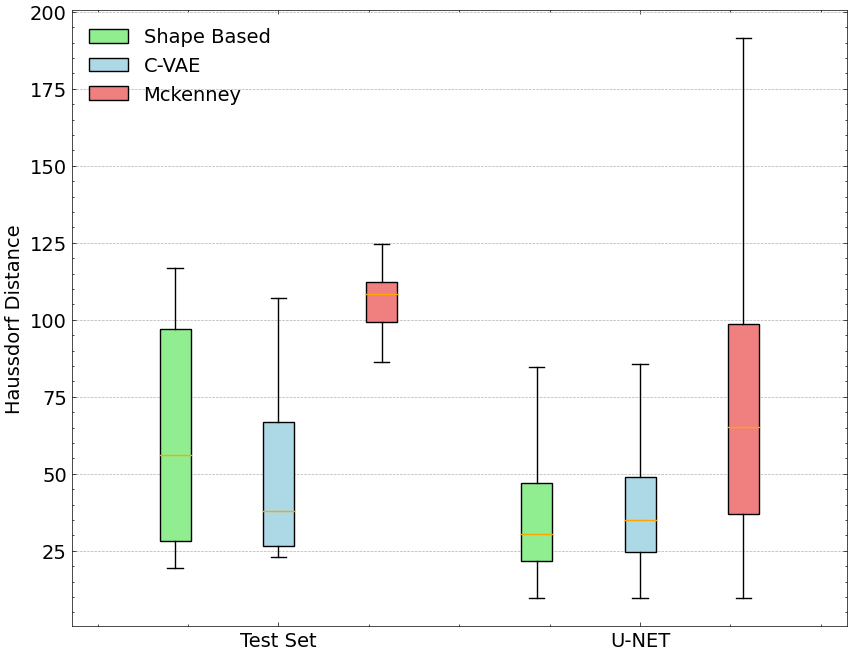

In [46]:
data_ts = [hd_list_shp_ts, hd_list_cvae_ts, hd_list_pstg_ts]
data_pr = [hd_list_shp_pr, hd_list_cvae_pr, hd_list_pstg_pr]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# left position of bars on x-axis
left = [1, 1.5, 2]
# right position of bars on x-axis
right = [2.75, 3.25, 3.75]

# labels for bars
tick_label = ['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom']

# Create the boxplot with median annotation, showfliers=False, shape based green, cvae blue, pstg red
boxplot_ts = ax.boxplot(data_ts,
                        positions=left,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=2),
                        patch_artist=True)

# Create the boxplot with median annotation, showfliers=False, shape based green, cvae blue, pstg red
boxplot_unet = ax.boxplot(data_pr,
                        positions=right,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=2),
                        patch_artist=True)

colors = ['lightgreen', 'lightblue', 'lightcoral', 'lightgreen', 'lightblue', 'lightcoral']
for patch, color in zip(boxplot_ts['boxes'], colors):
    patch.set_facecolor(color)

for patch, color in zip(boxplot_unet['boxes'], colors):
    patch.set_facecolor(color)

# Add dashed gridlines for y axis ONLY
ax.grid(linestyle='--', linewidth=0.5, axis='y')
# no x gridlines
ax.grid(False, axis='x')

# x labels
ax.set_xticks([1.5, 3.25])
ax.set_xticklabels(['Test Set', 'U-NET'])
# increase4 font size
ax.tick_params(axis='both', which='major', labelsize=14)

# add legend for each model, font size 14
ax.legend([boxplot_ts["boxes"][0], boxplot_ts["boxes"][1], boxplot_ts["boxes"][2]],
            ['Shape Based', 'C-VAE', 'Mckenney'], fontsize=14)  
# add y label
ax.set_ylabel('Haussdorf Distance', fontsize=14)

### IoU - Test Set

In [49]:
# CVAE
model_polys = [loads(wkt) for wkt in cvae_wkt]
iou_list_cvae_pr_ts  = list()
print("Calculating IoU...")
for i in range(len(g_t_polys)):
    iou = g_t_polys[i].intersection(model_polys[i]).area / g_t_polys[i].union(model_polys[i]).area
    iou_list_cvae_pr_ts .append(iou)
    
iou_mean_cvae_pr_ts = sum(iou_list_cvae_pr_ts) / len(iou_list_cvae_pr_ts)

Calculating IoU...


In [51]:
# Shape based
model_polys = [loads(wkt) for wkt in shp_wkt]
iou_list_shp_pr_ts  = list()
print("Calculating IoU...")
for i in range(len(g_t_polys)):
    iou = g_t_polys[i].intersection(model_polys[i]).area / g_t_polys[i].union(model_polys[i]).area
    iou_list_shp_pr_ts .append(iou)

iou_mean_shp_pr_ts = sum(iou_list_shp_pr_ts) / len(iou_list_shp_pr_ts)

Calculating IoU...


In [54]:
# Pyspatiotemporalgeom
model_polys = [loads(wkt) for wkt in pstg_wkt]
iou_list_pstg_pr_ts  = list()
print("Calculating IoU...")
for i in range(len(g_t_polys)):
    iou = g_t_polys[i].intersection(model_polys[i]).area / g_t_polys[i].union(model_polys[i]).area
    iou_list_pstg_pr_ts .append(iou)

iou_mean_pstg_pr_ts = sum(iou_list_pstg_pr_ts) / len(iou_list_pstg_pr_ts)

Calculating IoU...


In [55]:
# print mean, std, min and max values
print(f"Conditional VAE interpolation: mean IoU {iou_mean_cvae_pr_ts:.3f}, std {np.std(iou_list_cvae_pr_ts):.3f}, min {min(iou_list_cvae_pr_ts):.3f}, max {max(iou_list_cvae_pr_ts):.3f} \n")
print(f"Shape based interpolation: mean IoU {iou_mean_shp_pr_ts:.3f}, std {np.std(iou_list_shp_pr_ts):.3f}, min {min(iou_list_shp_pr_ts):.3f}, max {max(iou_list_shp_pr_ts):.3f} \n")
print(f"Pyspatiotemporalgeom interpolation: mean IoU {iou_mean_pstg_pr_ts:.3f}, std {np.std(iou_list_pstg_pr_ts):.3f}, min {min(iou_list_pstg_pr_ts):.3f}, max {max(iou_list_pstg_pr_ts):.3f} \n")


Conditional VAE interpolation: mean IoU 0.949, std 0.017, min 0.916, max 0.974 

Shape based interpolation: mean IoU 0.959, std 0.016, min 0.925, max 0.977 

Pyspatiotemporalgeom interpolation: mean IoU 0.822, std 0.073, min 0.493, max 0.864 



### Boxplots: IoU Test Set

Text(0, 0.5, 'Jaccard Index')

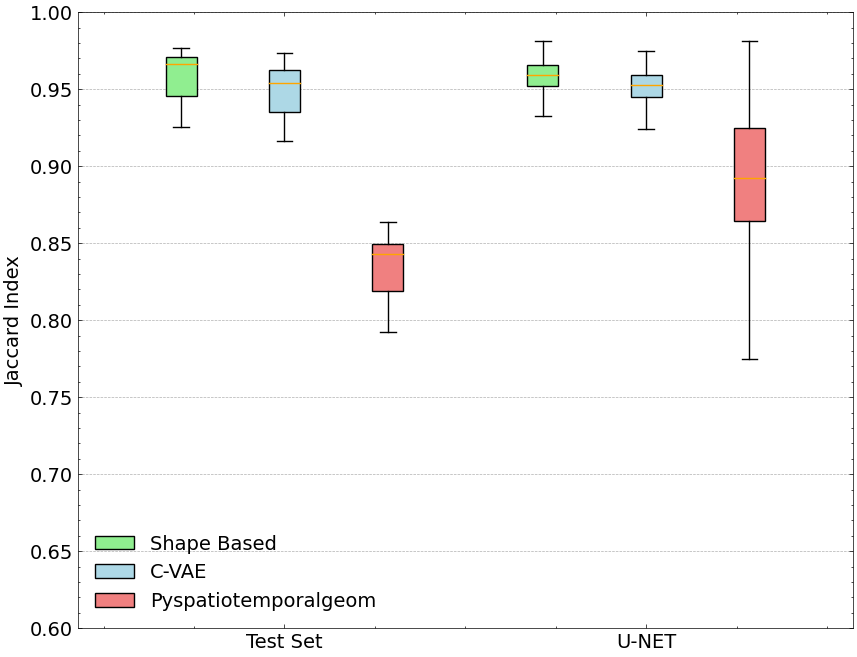

In [56]:
# plot IoU for UNET and test set comparison
# Combine the data into a list
data_ts = [iou_list_shp_pr_ts, iou_list_cvae_pr_ts, iou_list_pstg_pr_ts]
data_unet = [iou_list_shp_pr, iou_list_cvae_pr, iou_list_pstg_pr]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))
# y-axis from 0 to 1
ax.set_ylim(0.6, 1)

# left position of bars on x-axis
left = [1, 1.5, 2]
# right position of bars on x-axis
right = [2.75, 3.25, 3.75]
 
# labels for bars
tick_label = ['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom']

# Create the boxplot with median annotation, showfliers=False, shape based green, cvae blue, pstg red
boxplot_ts = ax.boxplot(data_ts,
                        positions=left,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=2),
                        patch_artist=True)

# Create the boxplot with median annotation, showfliers=False, shape based green, cvae blue, pstg red
boxplot_unet = ax.boxplot(data_unet,
                        positions=right,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=2),
                        patch_artist=True)
                    

colors = ['lightgreen', 'lightblue', 'lightcoral', 'lightgreen', 'lightblue', 'lightcoral']
for patch, color in zip(boxplot_ts['boxes'], colors):
    patch.set_facecolor(color)

for patch, color in zip(boxplot_unet['boxes'], colors):
    patch.set_facecolor(color)

# Add dashed gridlines for y axis ONLY
ax.grid(linestyle='--', linewidth=0.5, axis='y')
# no x gridlines
ax.grid(False, axis='x')

# x labels
ax.set_xticks([1.5, 3.25])
ax.set_xticklabels(['Test Set', 'U-NET'])
# increase4 font size
ax.tick_params(axis='both', which='major', labelsize=14)

# add legend for each model, font size 14
ax.legend([boxplot_ts["boxes"][0], boxplot_ts["boxes"][1], boxplot_ts["boxes"][2]],
            ['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'], fontsize=14)  
# add y label
ax.set_ylabel('Jaccard Index', fontsize=14)

## Temporal Consistency (0,25 Hz Interpolations)

### Exponetial Strided TC

In [58]:
# Let a_n be some geometric progression a_n = a_1*r^(n−1)
n = np.arange(1,6)
a_1 = 1
r = 10
# calculate the geometric progression
a_n = a_1*r**(n-1)
strides = a_n
print(f"strides: {strides}")

strides: [    1    10   100  1000 10000]


In [59]:
# CVAE
print("Reading WKTs file...")
with open(CVAE_WKT_FILE, "r") as f:
    model_wkt = f.read().splitlines()

# delete samples
del model_wkt[::100]
num_polygons = len(model_wkt)

# read WKTS file lines and convert to list of shapely polygons
polygons = [loads(wkt) for wkt in model_wkt]
polygons = polygons[:num_polygons]
tc_list = list()

for str in strides:
    t_c = strided_temporal_consistency(polygons, num_polygons, str, exp = False)
    print(f"Conditional VAE interpolation: mean TC {t_c['tc_mean']:.4e} with stride {t_c['strd']} \n")
    tc_list.append(t_c)

Reading WKTs file...
Calculating the temporal consistency with stride 1...
Conditional VAE interpolation: mean TC 9.9756e-01 with stride 1 

Calculating the temporal consistency with stride 10...
Conditional VAE interpolation: mean TC 9.9775e-01 with stride 10 

Calculating the temporal consistency with stride 100...
Conditional VAE interpolation: mean TC 9.9792e-01 with stride 100 

Calculating the temporal consistency with stride 1000...
Conditional VAE interpolation: mean TC 9.8743e-01 with stride 1000 

Calculating the temporal consistency with stride 10000...
Conditional VAE interpolation: mean TC 9.8201e-01 with stride 10000 



In [60]:
# Shape based
print("Reading WKTs file...")
with open(SHP_WKT_FILE, "r") as f:
    model_wkt = f.read().splitlines()

# delete samples
del model_wkt[::100]
num_polygons = len(model_wkt)

# read WKTS file lines and convert to list of shapely polygons
polygons = [loads(wkt) for wkt in model_wkt]
polygons = polygons[:num_polygons]

tc_shp_list = list()
for str in strides:
    t_c = strided_temporal_consistency(polygons, num_polygons, str, exp = False)
    print(f"Shape based interpolation: mean TC {t_c['tc_mean']:.4e} with stride {t_c['strd']} \n")
    tc_shp_list.append(t_c)

Reading WKTs file...
Calculating the temporal consistency with stride 1...
Shape based interpolation: mean TC 9.9974e-01 with stride 1 

Calculating the temporal consistency with stride 10...
Shape based interpolation: mean TC 9.9744e-01 with stride 10 

Calculating the temporal consistency with stride 100...
Shape based interpolation: mean TC 9.8064e-01 with stride 100 

Calculating the temporal consistency with stride 1000...
Shape based interpolation: mean TC 9.7121e-01 with stride 1000 

Calculating the temporal consistency with stride 10000...
Shape based interpolation: mean TC 9.8029e-01 with stride 10000 



In [61]:
# Pyspatiotemporalgeom
print("Reading WKTs file...")
with open( PSTG_WKT_FILE, "r") as f:
    model_wkt = f.read().splitlines()

# delete samples
del model_wkt[::100]
num_polygons = len(model_wkt)

# read WKTS file lines and convert to list of shapely polygons
polygons = [loads(wkt) for wkt in model_wkt]
polygons = polygons[:num_polygons]

tc_pstg_list = list()

for str in strides:
    t_c = strided_temporal_consistency(polygons, num_polygons, str, exp = False)
    print(f"Pyspatiotemporalgeom interpolation: mean TC {t_c['tc_mean']:.4e} with stride {t_c['strd']} \n")
    tc_pstg_list.append(t_c)

Reading WKTs file...
Calculating the temporal consistency with stride 1...


c:\Users\tiago\miniconda3\envs\interpol\lib\site-packages\shapely\set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)


Pyspatiotemporalgeom interpolation: mean TC 9.9524e-01 with stride 1 

Calculating the temporal consistency with stride 10...
Pyspatiotemporalgeom interpolation: mean TC 9.6766e-01 with stride 10 

Calculating the temporal consistency with stride 100...
Pyspatiotemporalgeom interpolation: mean TC 9.5177e-01 with stride 100 

Calculating the temporal consistency with stride 1000...
Pyspatiotemporalgeom interpolation: mean TC 9.5128e-01 with stride 1000 

Calculating the temporal consistency with stride 10000...
Pyspatiotemporalgeom interpolation: mean TC 9.8606e-01 with stride 10000 



In [62]:
# print mean, std, min, max (compactly)
print(f"Conditional VAE interpolation: mean TC {np.mean([tc['tc_mean'] for tc in tc_list]):.4e} sd {np.std([tc['tc_mean'] for tc in tc_list]):.4e} min {np.min([tc['tc_mean'] for tc in tc_list]):.4e} max {np.max([tc['tc_mean'] for tc in tc_list]):.4e} \n")
print(f"Shape based interpolation: mean TC {np.mean([tc['tc_mean'] for tc in tc_shp_list]):.4e} sd {np.std([tc['tc_mean'] for tc in tc_shp_list]):.4e} min {np.min([tc['tc_mean'] for tc in tc_shp_list]):.4e} max {np.max([tc['tc_mean'] for tc in tc_shp_list]):.4e} \n")
print(f"Pyspatiotemporalgeom interpolation: mean TC {np.mean([tc['tc_mean'] for tc in tc_pstg_list]):.4e} sd {np.std([tc['tc_mean'] for tc in tc_pstg_list]):.4e} min {np.min([tc['tc_mean'] for tc in tc_pstg_list]):.4e} max {np.max([tc['tc_mean'] for tc in tc_pstg_list]):.4e} \n")

Conditional VAE interpolation: mean TC 9.9253e-01 sd 6.6068e-03 min 9.8201e-01 max 9.9792e-01 

Shape based interpolation: mean TC 9.8586e-01 sd 1.0950e-02 min 9.7121e-01 max 9.9974e-01 

Pyspatiotemporalgeom interpolation: mean TC 9.7040e-01 sd 1.7788e-02 min 9.5128e-01 max 9.9524e-01 



### Boxplots and tables: Exp. Strided TC

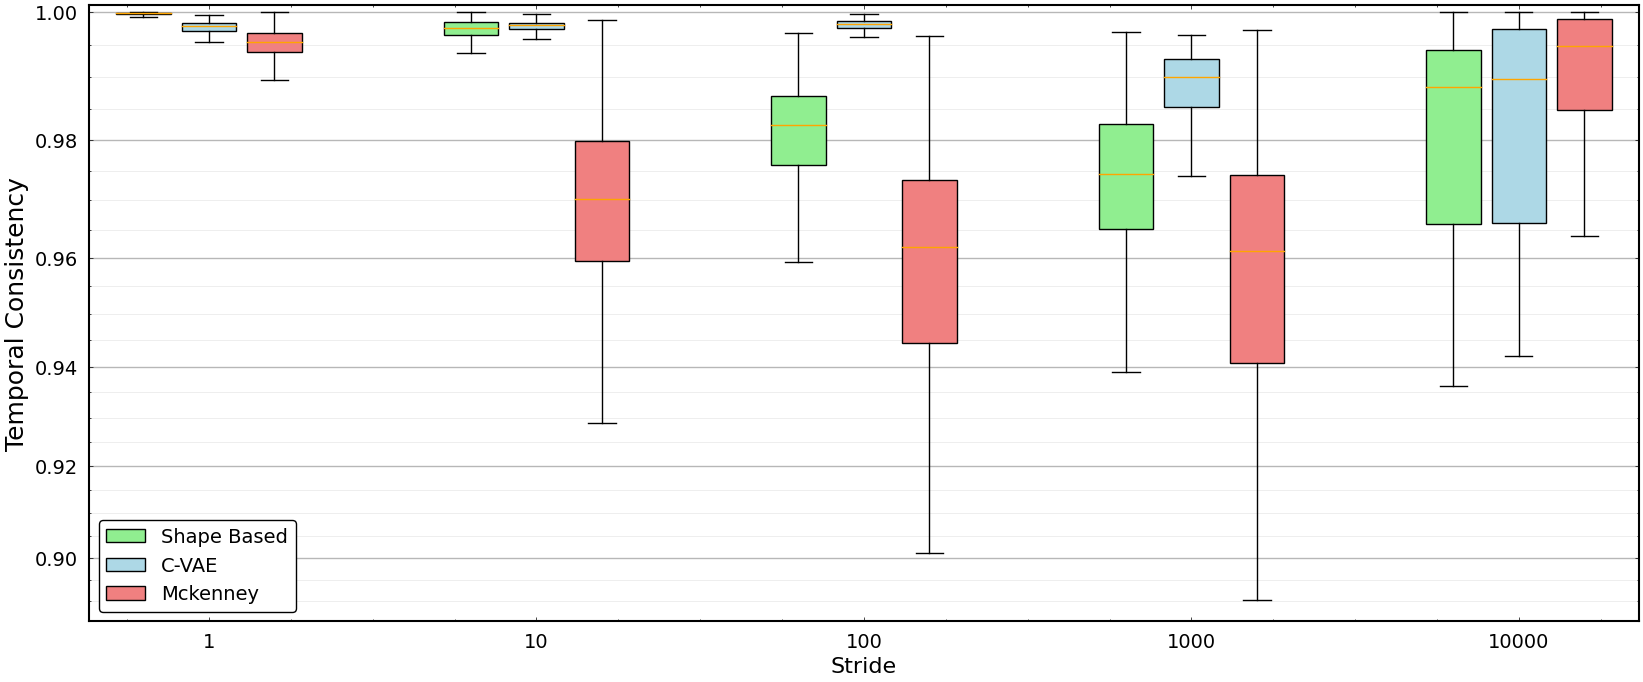

In [63]:
# combine the data into a list and orders it according to the stide values
data = [tc_shp_list[0]['tc'], tc_list[0]['tc'], tc_pstg_list[0]['tc'],
        tc_shp_list[1]['tc'], tc_list[1]['tc'], tc_pstg_list[1]['tc'],
        tc_shp_list[2]['tc'], tc_list[2]['tc'], tc_pstg_list[2]['tc'],
        tc_shp_list[3]['tc'], tc_list[3]['tc'], tc_pstg_list[3]['tc'],
        tc_shp_list[4]['tc'], tc_list[4]['tc'], tc_pstg_list[4]['tc']]


plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(20, 8))

# y-axis from 0 to 1


# positions of the boxplots
pos = [1.4, 2, 2.6, 4.4, 5, 5.6, 7.4, 8, 8.6, 10.4, 11, 11.6, 13.4, 14, 14.6]

# Create the boxplot with median annotation, showfliers=False, shape based green, cvae blue, pstg red
boxplot = ax.boxplot(data,
                        positions=pos,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=1),
                        patch_artist=True)

colors = ['lightgreen', 'lightblue', 'lightcoral'] *5

for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)



# Add dashed gridlines for y axis ONLY

# major ticks every 0.1, minor ticks every 0.05
major_ticks = np.arange(0.05, 1.001, 0.05)
minor_ticks = np.arange(0.05, 1.001, 0.01)

ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

ax.set_xticks([2, 5, 8, 11, 14]);
ax.set_xticklabels(['1', '10', '100', '1000', '10000']);
# And a corresponding grid

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.3, linewidth=0.5, axis='y')
ax.grid(which='major', alpha=0.9, linewidth=1, axis='y')
ax.tick_params(labelsize=14)
# disable x axis grid

# y limits
ax.set_ylim(0.885, 1.001)

# y axis custom scale
def forward(x):
    return x**(5)
def inverse(x):
    return x**1/5
ax.set_yscale('function', functions=(forward, inverse))


# add legend for each model, font size 14, white box, black border rounded corners
ax.legend([boxplot["boxes"][0], boxplot["boxes"][1], boxplot["boxes"][2]], 
['Shape Based', 'C-VAE', 'Mckenney'],  fontsize=14, 
framealpha=1, frameon=True, facecolor='white', edgecolor='black', fancybox=True)

# add y label
ax.set_ylabel('Temporal Consistency', fontsize=18)

# add x label
ax.set_xlabel('Stride', fontsize=16)
ax.grid(False, axis='x')

plt.show()

# Distance Sampled Interpolations

## Comparison with **UNET** generated segmentations

### IoU

In [67]:
iou_shp_mean_dst, iou_list_shp_dst = iou_wkt(UNET_WKT_FILE, SHP_WKT_FILE_SAMPLED, num_polygons=NUM_POLYGONS)
iou_cvae_mean_dst, iou_list_cvae_dst = iou_wkt(UNET_WKT_FILE, CVAE_WKT_FILE_SAMPLED, num_polygons=NUM_POLYGONS)
iou_pstg_mean_dst, iou_list_pstg_dst = iou_wkt(UNET_WKT_FILE, PSTG_WKT_FILE_SAMPLED, num_polygons=NUM_POLYGONS)

Reading WKTs files...
Calculating IoU...
Reading WKTs files...
Calculating IoU...
Reading WKTs files...
Calculating IoU...


In [68]:
print(f"Shape based interpolation: meanIou {iou_shp_mean_dst:.3f}, std {np.std(iou_list_shp_dst):.3f}, min {np.min(iou_list_shp_dst):.3f}, max {np.max(iou_list_shp_dst):.3f} \n")
print(f"Conditional VAE interpolation: meanIoU {iou_cvae_mean_dst:.3f}, std {np.std(iou_list_cvae_dst):.3f}, min {np.min(iou_list_cvae_dst):.3f}, max {np.max(iou_list_cvae_dst):.3f} \n")
print(f"Pyspatiotemporalgeom interpolation: meanIoU {iou_pstg_mean_dst:.3f}, std {np.std(iou_list_pstg_dst):.3f}, min {np.min(iou_list_pstg_dst):.3f}, max {np.max(iou_list_pstg_dst):.3f} \n")

Shape based interpolation: meanIou 0.928, std 0.020, min 0.845, max 0.982 

Conditional VAE interpolation: meanIoU 0.905, std 0.026, min 0.825, max 0.987 

Pyspatiotemporalgeom interpolation: meanIoU 0.876, std 0.040, min 0.763, max 0.978 



### Hausdorf Distance

In [71]:
hd_shp_mean_pr_sp, hd_list_shp_pr_sp = hausdorff_dist_wkt(UNET_WKT_FILE, SHP_WKT_FILE_SAMPLED, last_frame=NUM_POLYGONS, discard_100=True)
hd_cvae_mean_pr_sp, hd_list_cvae_pr_sp = hausdorff_dist_wkt(UNET_WKT_FILE, CVAE_WKT_FILE_SAMPLED, last_frame=NUM_POLYGONS, discard_100=True)
hd_pstg_mean_pr_sp, hd_list_pstg_pr_sp = hausdorff_dist_wkt(UNET_WKT_FILE, PSTG_WKT_FILE_SAMPLED, last_frame=NUM_POLYGONS, discard_100=True)

Reading WKTs files...
Calculating Hausdorf Distance...
Reading WKTs files...
Calculating Hausdorf Distance...
Reading WKTs files...
Calculating Hausdorf Distance...


In [72]:
print(f"Shape based interpolation: mean Hausdorf Dist. {hd_shp_mean_pr_sp:.3f}, std {np.std(hd_list_shp_pr_sp):.3f}, min {np.min(hd_list_shp_pr_sp):.3f}, max {np.max(hd_list_shp_pr_sp):.3f} \n")
print(f"Conditional VAE interpolation: mean Hausdorf Dist. {hd_cvae_mean_pr_sp:.3f}, std {np.std(hd_list_cvae_pr_sp):.3f}, min {np.min(hd_list_cvae_pr_sp):.3f}, max {np.max(hd_list_cvae_pr_sp):.3f} \n")
print(f"Pyspatiotemporalgeom interpolation: mean Hausdorf Dist. {hd_pstg_mean_pr_sp:.3f}, std {np.std(hd_list_pstg_pr_sp):.3f}, min {np.min(hd_list_pstg_pr_sp):.3f}, max {np.max(hd_list_pstg_pr_sp):.3f} \n")

Shape based interpolation: mean Hausdorf Dist. 68.315, std 38.443, min 10.296, max 306.026 

Conditional VAE interpolation: mean Hausdorf Dist. 76.464, std 52.362, min 16.000, max 338.095 

Pyspatiotemporalgeom interpolation: mean Hausdorf Dist. 85.426, std 38.922, min 10.471, max 269.194 



## Comparison with the BurnedAreaUAV **Test set**

### Data preparation

In [74]:
# test set frame indexes 
idx = np.linspace(20250, 22450, 23).astype(int)  

# Read WKTS files
print("Reading WKTs files...")
with open(BA_UAV_WKT, "r") as f:
    test_wkt = f.read().splitlines()

with open(SHP_WKT_FILE_SAMPLED, "r") as f:
    shp_wkt = f.read().splitlines()

with open(CVAE_WKT_FILE_SAMPLED, "r") as f:
    cvae_wkt = f.read().splitlines()

with open(PSTG_WKT_FILE_SAMPLED, "r") as f:
    pstg_wkt = f.read().splitlines()

print("Filtering WKTs files...")
shp_wkt = [shp_wkt[i] for i in idx]
cvae_wkt = [cvae_wkt[i] for i in idx]
pstg_wkt = [pstg_wkt[i] for i in idx]
# print the length of all wkt files
print(f"Shape based interpolation: {len(shp_wkt)} frames")
print(f"Conditional VAE interpolation: {len(cvae_wkt)} frames")
print(f"Pyspatiotemporalgeom interpolation: {len(pstg_wkt)} frames ")
print(f"Test set: {len(test_wkt)} frames")

Reading WKTs files...
Filtering WKTs files...
Shape based interpolation: 23 frames
Conditional VAE interpolation: 23 frames
Pyspatiotemporalgeom interpolation: 23 frames 
Test set: 23 frames


### Hausdorf Distance 

In [ ]:
# converts Test set ground truth polygon to shapely format
g_t_polys = [loads(wkt) for wkt in test_wkt]

# Shape based interpolation
model_polys = [loads(wkt) for wkt in shp_wkt]
hd_list_shp_ts_sp  = list()
print("Calculating Hausdorf Distance...")
for i in range(len(g_t_polys)):
    g_t_polys[i] =  make_valid(g_t_polys[i])
    model_polys[i] = make_valid(model_polys[i])
    hausdorff_dist = g_t_polys[i].hausdorff_distance(model_polys[i])
    hd_list_shp_ts_sp.append(hausdorff_dist)    

hd_mean_shp_ts_sp = np.mean(hd_list_shp_ts_sp)

In [ ]:
# CVAE
model_polys = [loads(wkt) for wkt in cvae_wkt]
hd_list_cvae_ts_sp = list()
print("Calculating Hausdorf Distance...")
for i in range(len(g_t_polys)):
    g_t_polys[i]=  make_valid(g_t_polys[i])
    model_polys[i] = make_valid(model_polys[i])
    hausdorff_dist = g_t_polys[i].hausdorff_distance(model_polys[i])
    hd_list_cvae_ts_sp.append(hausdorff_dist)    

hd_mean_cvae_ts_sp = np.mean(hd_list_cvae_ts_sp)

In [ ]:
# PSTG
model_polys = [loads(wkt) for wkt in pstg_wkt]
hd_list_pstg_ts_sp = list()
print("Calculating Hausdorf Distance...")
for i in range(len(g_t_polys)):
    g_t_polys[i]=  make_valid(g_t_polys[i])
    model_polys[i] = make_valid(model_polys[i])
    hausdorff_dist = g_t_polys[i].hausdorff_distance(model_polys[i])
    hd_list_pstg_ts_sp.append(hausdorff_dist)    

hd_mean_pstg_ts_sp = np.mean(hd_list_pstg_ts_sp)

In [78]:
print("Distance Sampled Interpolation")
print(f"Shape based interpolation: mean Hausdorf Dist. {hd_mean_shp_ts_sp:.3f}, std {np.std(hd_list_shp_ts_sp):.3f}, min {np.min(hd_list_shp_ts_sp):.3f}, max {np.max(hd_list_shp_ts_sp):.3f} ")
print(f"Conditional VAE interpolation: mean Hausdorf Dist. {hd_mean_cvae_ts_sp:.3f}, std {np.std(hd_list_cvae_ts_sp):.3f}, min {np.min(hd_list_cvae_ts_sp):.3f}, max {np.max(hd_list_cvae_ts_sp):.3f} ")
print(f"Pyspatiotemporalgeom interpolation: mean Hausdorf Dist. {hd_mean_pstg_ts_sp:.3f}, std {np.std(hd_list_pstg_ts_sp):.3f}, min {np.min(hd_list_pstg_ts_sp):.3f}, max {np.max(hd_list_pstg_ts_sp):.3f} ")

Distance Sampled Interpolation
Shape based interpolation: mean Hausdorf Dist. 108.349, std 8.631, min 91.984, max 125.539 
Conditional VAE interpolation: mean Hausdorf Dist. 85.220, std 14.827, min 52.773, max 108.853 
Pyspatiotemporalgeom interpolation: mean Hausdorf Dist. 103.068, std 30.744, min 23.014, max 146.521 


Text(0, 0.5, 'Haussdorf Distance')

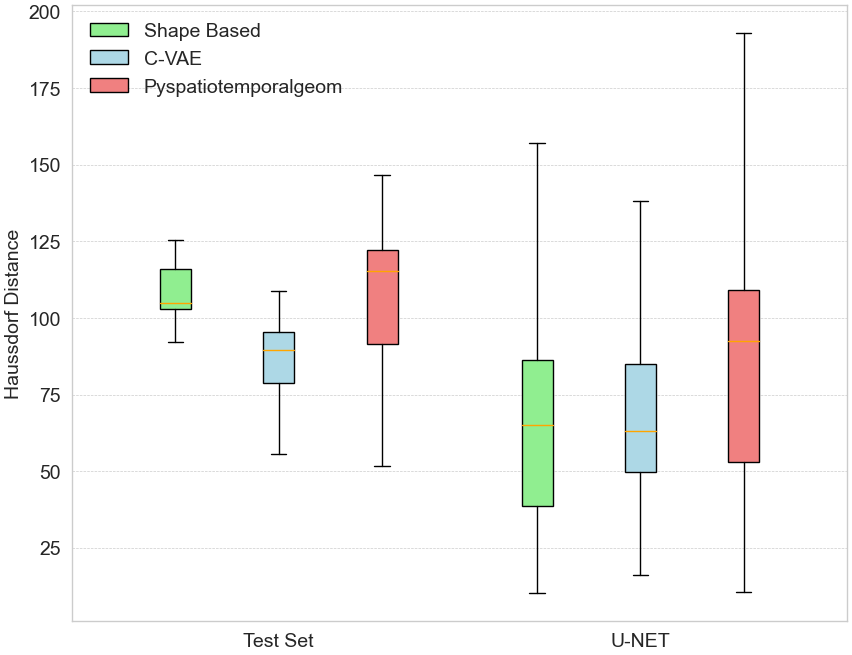

In [80]:
data_ts = [hd_list_shp_ts_sp, hd_list_cvae_ts_sp, hd_list_pstg_ts_sp]
data_pr = [hd_list_shp_pr_sp, hd_list_cvae_pr_sp, hd_list_pstg_pr_sp]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# left position of bars on x-axis
left = [1, 1.5, 2]
# right position of bars on x-axis
right = [2.75, 3.25, 3.75]

# labels for bars
tick_label = ['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom']

# Create the boxplot with median annotation, showfliers=False, shape based green, cvae blue, pstg red
boxplot_ts = ax.boxplot(data_ts,
                        positions=left,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=2),
                        patch_artist=True)

# Create the boxplot with median annotation, showfliers=False, shape based green, cvae blue, pstg red
boxplot_unet = ax.boxplot(data_pr,
                        positions=right,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=2),
                        patch_artist=True)

colors = ['lightgreen', 'lightblue', 'lightcoral', 'lightgreen', 'lightblue', 'lightcoral']
for patch, color in zip(boxplot_ts['boxes'], colors):
    patch.set_facecolor(color)

for patch, color in zip(boxplot_unet['boxes'], colors):
    patch.set_facecolor(color)

# Add dashed gridlines for y axis ONLY
ax.grid(linestyle='--', linewidth=0.5, axis='y')
# no x gridlines
ax.grid(False, axis='x')

# x labels
ax.set_xticks([1.5, 3.25])
ax.set_xticklabels(['Test Set', 'U-NET'])
# increase4 font size
ax.tick_params(axis='both', which='major', labelsize=14)

# add legend for each model, font size 14
ax.legend([boxplot_ts["boxes"][0], boxplot_ts["boxes"][1], boxplot_ts["boxes"][2]],
            ['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'], fontsize=14)  
# add y label
ax.set_ylabel('Haussdorf Distance', fontsize=14)

### IoU

In [82]:
# CVAE
model_polys = [loads(wkt) for wkt in cvae_wkt]
iou_list_cvae_dst_ts = list()
print("Calculating IoU...")
for i in range(len(g_t_polys)):
    iou = g_t_polys[i].intersection(model_polys[i]).area / g_t_polys[i].union(model_polys[i]).area
    iou_list_cvae_dst_ts.append(iou)
    
iou_mean_cvae_dst_ts = sum(iou_list_cvae_dst_ts) / len(iou_list_cvae_dst_ts)

Calculating IoU...


In [84]:
# Shape based
model_polys = [loads(wkt) for wkt in shp_wkt]
iou_list_shp_dst_ts = list()
print("Calculating IoU...")
for i in range(len(g_t_polys)):
    iou = g_t_polys[i].intersection(model_polys[i]).area / g_t_polys[i].union(model_polys[i]).area
    iou_list_shp_dst_ts.append(iou)

iou_mean_shp_dst_ts = sum(iou_list_shp_dst_ts) / len(iou_list_shp_dst_ts)

Calculating IoU...


In [85]:
# Pyspatiotemporalgeom
model_polys = [loads(wkt) for wkt in pstg_wkt]
iou_list_pstg_dst_ts = list()
print("Calculating IoU...")
for i in range(len(g_t_polys)):
    iou = g_t_polys[i].intersection(model_polys[i]).area / g_t_polys[i].union(model_polys[i]).area
    iou_list_pstg_dst_ts.append(iou)

iou_mean_pstg_dst_ts = sum(iou_list_pstg_dst_ts) / len(iou_list_pstg_dst_ts)

Calculating IoU...


In [86]:

print(f"Shape based interpolation: mean IoU {iou_mean_shp_dst_ts:.3f}, std {np.std(iou_list_shp_dst_ts):.3f}, min {min(iou_list_shp_dst_ts):.3f}, max {max(iou_list_shp_dst_ts):.3f} \n")
print(f"Conditional VAE interpolation: mean IoU {iou_mean_cvae_dst_ts:.3f}, std {np.std(iou_list_cvae_dst_ts):.3f} , min {min(iou_list_cvae_dst_ts):.3f}, max {max(iou_list_cvae_dst_ts):.3f} \n")
print(f"Pyspatiotemporalgeom interpolation: mean IoU {iou_mean_pstg_dst_ts:.3f}, std {np.std(iou_list_pstg_dst_ts):.3f}, min {min(iou_list_pstg_dst_ts):.3f}, max {max(iou_list_pstg_dst_ts):.3f} \n")

Shape based interpolation: mean IoU 0.930, std 0.021, min 0.887, max 0.964 

Conditional VAE interpolation: mean IoU 0.910, std 0.011 , min 0.889, max 0.928 

Pyspatiotemporalgeom interpolation: mean IoU 0.850, std 0.038, min 0.799, max 0.960 



### Boxplots: IoU

Text(0, 0.5, 'Jaccard Index')

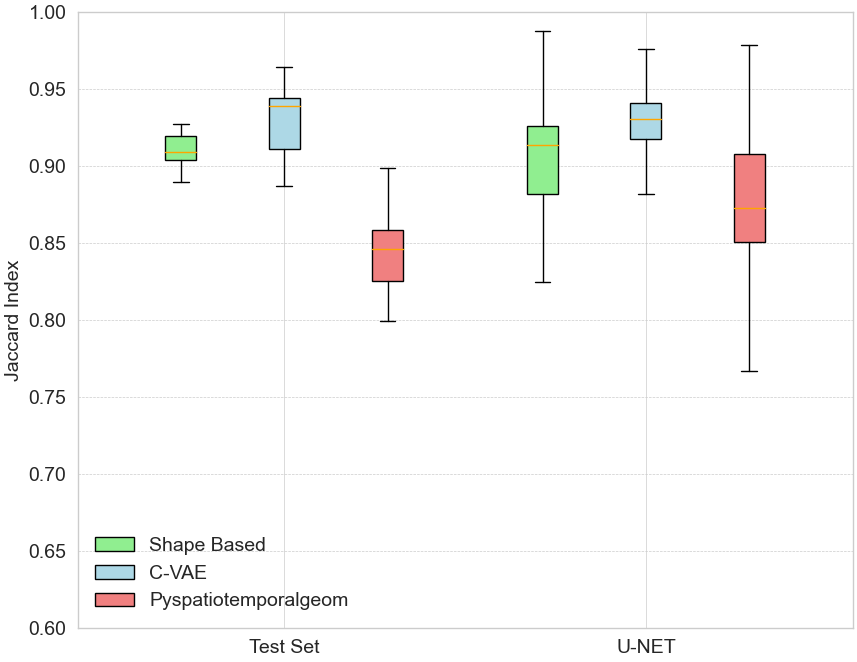

In [87]:
# plot IoU for UNET and test set comparison
# Combine the data into a list
data_ts = [iou_list_cvae_dst_ts, iou_list_shp_dst_ts, iou_list_pstg_dst_ts]
data_unet = [iou_list_cvae_dst, iou_list_shp_dst, iou_list_pstg_dst]

# Set up the figure and axes~
fig, ax = plt.subplots(figsize=(10, 8))


# y-axis from 0 to 1
ax.set_ylim(0.6, 1)

# left position of bars on x-axis
left = [1, 1.5, 2]
# right position of bars on x-axis
right = [2.75, 3.25, 3.75]
 
# labels for bars
tick_label = ['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom']

# Create the boxplot with median annotation, showfliers=False, shape based green, cvae blue, pstg red
boxplot_ts = ax.boxplot(data_ts,
                        positions=left,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=2),
                        patch_artist=True)

# Create the boxplot with median annotation, showfliers=False, shape based green, cvae blue, pstg red
boxplot_unet = ax.boxplot(data_unet,
                        positions=right,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=2),
                        patch_artist=True)

# Add dashed gridlines ONLY for y-axis
ax.grid(linestyle='--', linewidth=0.5, axis='y')

# x labels


colors = ['lightgreen', 'lightblue', 'lightcoral', 'lightgreen', 'lightblue', 'lightcoral']
for patch, color in zip(boxplot_ts['boxes'], colors):
    patch.set_facecolor(color)

for patch, color in zip(boxplot_unet['boxes'], colors):
    patch.set_facecolor(color)

# Add dashed gridlines for y axis ONLY
ax.grid(linestyle='--', linewidth=0.5, axis='y')

# x labels
ax.set_xticks([1.5, 3.25])
# right position of bars on x-axis
ax.set_xticklabels(['Test Set', 'U-NET'])
# increase4 font size
ax.tick_params(axis='both', which='major', labelsize=14)

# add legend for each model, font size 14
ax.legend([boxplot_ts["boxes"][0], boxplot_ts["boxes"][1], boxplot_ts["boxes"][2]],
            ['Shape Based', 'C-VAE', 'Pyspatiotemporalgeom'], fontsize=14)  
# add y label
ax.set_ylabel('Jaccard Index', fontsize=14)

## Temporal Consistency (Distance Sampled Interpolations)

### Exponetial Strided TC

In [89]:
# CVAE
print("Reading WKTs file...")
with open(CVAE_WKT_FILE_SAMPLED, "r") as f:
    model_wkt = f.read().splitlines()

# delete lines with number = idx_sampled (one liner)
model_wkt = [item for i, item in enumerate(model_wkt) if i not in idx_sampled]
num_polygons = len(model_wkt)

# read WKTS file lines and convert to list of shapely polygons
polygons = [loads(wkt) for wkt in model_wkt]
polygons = polygons[:num_polygons]
tc_cvae_list_sp = list()


for str in strides:
    t_c = strided_temporal_consistency(polygons, num_polygons, str, exp = False)
    print(f"Conditional VAE interpolation: mean TC {t_c['tc_mean']:.4e} with stride {t_c['strd']} \n")
    tc_cvae_list_sp.append(t_c)

Reading WKTs file...
Calculating the temporal consistency with stride 1...
Conditional VAE interpolation: mean TC 9.9998e-01 with stride 1 

Calculating the temporal consistency with stride 10...
Conditional VAE interpolation: mean TC 9.9989e-01 with stride 10 

Calculating the temporal consistency with stride 100...
Conditional VAE interpolation: mean TC 9.9980e-01 with stride 100 

Calculating the temporal consistency with stride 1000...
Conditional VAE interpolation: mean TC 9.9967e-01 with stride 1000 

Calculating the temporal consistency with stride 10000...
Conditional VAE interpolation: mean TC 9.9657e-01 with stride 10000 



In [90]:
# Pyspatiotemporalgeom
print("Reading WKTs file...")
with open(PSTG_WKT_FILE_SAMPLED, "r") as f:
    model_wkt = f.read().splitlines()

# delete lines with number = idx_sampled (one liner)
model_wkt = [item for i, item in enumerate(model_wkt) if i not in idx_sampled]
num_polygons = len(model_wkt)

# read WKTS file lines and convert to list of shapely polygons
polygons = [loads(wkt) for wkt in model_wkt]
polygons = polygons[:num_polygons]
tc_pstG_list_sp = list()

for str in strides:
    t_c = strided_temporal_consistency(polygons, num_polygons, str, exp = False)
    print(f"Pyspatiotemporalgeom interpolation: mean TC {t_c['tc_mean']:.4e} with stride {t_c['strd']} \n")
    tc_pstG_list_sp.append(t_c)

Reading WKTs file...
Calculating the temporal consistency with stride 1...
Pyspatiotemporalgeom interpolation: mean TC 9.9974e-01 with stride 1 

Calculating the temporal consistency with stride 10...
Pyspatiotemporalgeom interpolation: mean TC 9.9751e-01 with stride 10 

Calculating the temporal consistency with stride 100...
Pyspatiotemporalgeom interpolation: mean TC 9.8103e-01 with stride 100 

Calculating the temporal consistency with stride 1000...
Pyspatiotemporalgeom interpolation: mean TC 9.4883e-01 with stride 1000 

Calculating the temporal consistency with stride 10000...
Pyspatiotemporalgeom interpolation: mean TC 9.8951e-01 with stride 10000 



In [91]:
# Shape based
print("Reading WKTs file...")
with open(SHP_WKT_FILE_SAMPLED, "r") as f:
    model_wkt = f.read().splitlines()

# delete lines with number = idx_sampled (one liner)
model_wkt = [item for i, item in enumerate(model_wkt) if i not in idx_sampled]
num_polygons = len(model_wkt)

# read WKTS file lines and convert to list of shapely polygons
polygons = [loads(wkt) for wkt in model_wkt]
polygons = polygons[:num_polygons]
tc_shp_list_sp = list()

for str in strides:
    t_c = strided_temporal_consistency(polygons, num_polygons, str, exp = False)
    print(f"Shape based interpolation: mean TC {t_c['tc_mean']:.4e} with stride {t_c['strd']} \n")
    tc_shp_list_sp.append(t_c)

Reading WKTs file...
Calculating the temporal consistency with stride 1...
Shape based interpolation: mean TC 9.9998e-01 with stride 1 

Calculating the temporal consistency with stride 10...
Shape based interpolation: mean TC 9.9980e-01 with stride 10 

Calculating the temporal consistency with stride 100...
Shape based interpolation: mean TC 9.9802e-01 with stride 100 

Calculating the temporal consistency with stride 1000...
Shape based interpolation: mean TC 9.8471e-01 with stride 1000 

Calculating the temporal consistency with stride 10000...
Shape based interpolation: mean TC 9.8897e-01 with stride 10000 



In [ ]:
# print mean, std, min, max (compactly)
print(f"CVAE sampled mean: {np.mean([tc_cvae_list_sp[i]['tc_mean'] for i in range(0, len(tc_cvae_list_sp))]):.4e}, sd: {np.std([tc_cvae_list_sp[i]['tc_mean'] for i in range(0, len(tc_cvae_list_sp))]):.4e}, min: {np.min([tc_cvae_list_sp[i]['tc_mean'] for i in range(0, len(tc_cvae_list_sp))]):.4e}, max: {np.max([tc_cvae_list_sp[i]['tc_mean'] for i in range(0, len(tc_cvae_list_sp))]):.4e}")
print(f"PSTG sampled mean: {np.mean([tc_pstG_list_sp[i]['tc_mean'] for i in range(0, len(tc_pstG_list_sp))]):.4e}, sd: {np.std([tc_pstG_list_sp[i]['tc_mean'] for i in range(0, len(tc_pstG_list_sp))]):.4e}, min: {np.min([tc_pstG_list_sp[i]['tc_mean'] for i in range(0, len(tc_pstG_list_sp))]):.4e}, max: {np.max([tc_pstG_list_sp[i]['tc_mean'] for i in range(0, len(tc_pstG_list_sp))]):.4e}")
print(f"SHP sampled mean: {np.mean([tc_shp_list_sp[i]['tc_mean'] for i in range(0, len(tc_shp_list_sp))]):.4e}, sd: {np.std([tc_shp_list_sp[i]['tc_mean'] for i in range(0, len(tc_shp_list_sp))]):.4e}, min: {np.min([tc_shp_list_sp[i]['tc_mean'] for i in range(0, len(tc_shp_list_sp))]):.4e}, max: {np.max([tc_shp_list_sp[i]['tc_mean'] for i in range(0, len(tc_shp_list_sp))]):.4e}")

CVAE sampled mean: 9.9918e-01, sd: 1.3102e-03, min: 9.9657e-01, max: 9.9998e-01
PSTG sampled mean: 9.8332e-01, sd: 1.8461e-02, min: 9.4883e-01, max: 9.9974e-01
SHP sampled mean: 9.9430e-01, sd: 6.2732e-03, min: 9.8471e-01, max: 9.9998e-01


### Boxplots: Temporal Consistency (Distance Sampled)

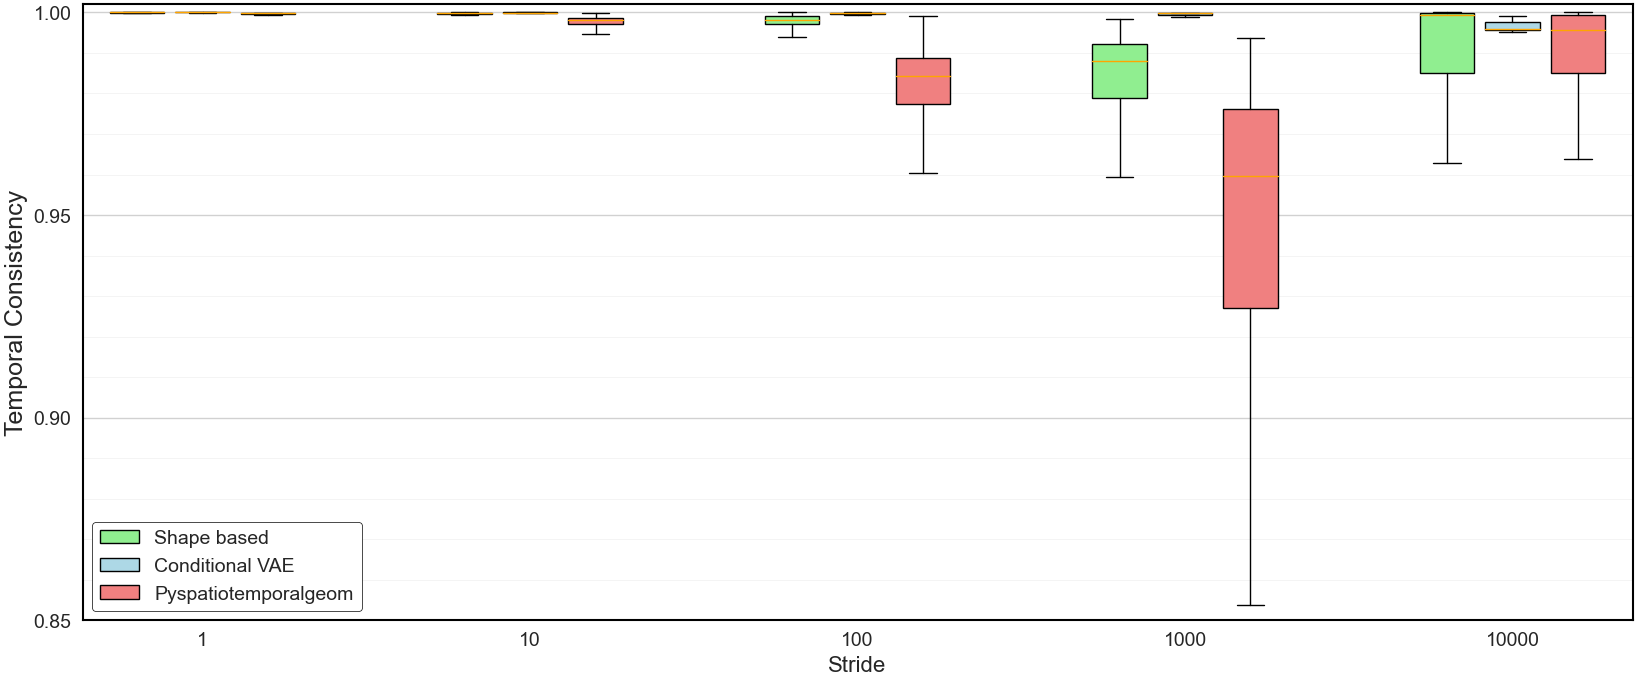

In [ ]:
# combine the data into a list and orders it according to the stide values
data = [tc_shp_list_sp[0]['tc'], tc_cvae_list_sp[0]['tc'], tc_pstG_list_sp[0]['tc'],
        tc_shp_list_sp[1]['tc'], tc_cvae_list_sp[1]['tc'], tc_pstG_list_sp[1]['tc'],
        tc_shp_list_sp[2]['tc'], tc_cvae_list_sp[2]['tc'], tc_pstG_list_sp[2]['tc'],
        tc_shp_list_sp[3]['tc'], tc_cvae_list_sp[3]['tc'], tc_pstG_list_sp[3]['tc'],
        tc_shp_list_sp[4]['tc'], tc_cvae_list_sp[4]['tc'], tc_pstG_list_sp[4]['tc']]


plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5
# width of outer boxplot
        
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(20, 8))

# positions of the boxplots
pos = [1.4, 2, 2.6, 4.4, 5, 5.6, 7.4, 8, 8.6, 10.4, 11, 11.6, 13.4, 14, 14.6]

# Create the boxplot with median annotation, showfliers=False, shape based green, cvae blue, pstg red
boxplot = ax.boxplot(data,
                        positions=pos,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=1),
                        patch_artist=True)

colors = ['lightgreen', 'lightblue', 'lightcoral'] *5

for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8

# Add dashed gridlines for y axis ONLY

# major ticks every 0.1, minor ticks every 0.05
major_ticks = np.arange(0.05, 1.005, 0.05)
minor_ticks = np.arange(0.05, 1.005, 0.01)

ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

ax.set_xticks([2, 5, 8, 11, 14]);
ax.set_xticklabels(['1', '10', '100', '1000', '10000']);
# And a corresponding grid

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.3, linewidth=0.5, axis='y')
ax.grid(which='major', alpha=0.9, linewidth=1, axis='y')
ax.tick_params(labelsize=14)
# disable x axis grid

# y limits
ax.set_ylim(0.85, 1.002)

# add legend for each model, font size 14, white box, black border rounded corners
ax.legend([boxplot["boxes"][0], boxplot["boxes"][1], boxplot["boxes"][2]], 
['Shape based', 'Conditional VAE', 'Pyspatiotemporalgeom'],  fontsize=14, 
framealpha=1, frameon=True, facecolor='white', edgecolor='black', fancybox=True)

# add y label
ax.set_ylabel('Temporal Consistency', fontsize=18)

# add x label
ax.set_xlabel('Stride', fontsize=16)
ax.grid(False, axis='x')

plt.show()

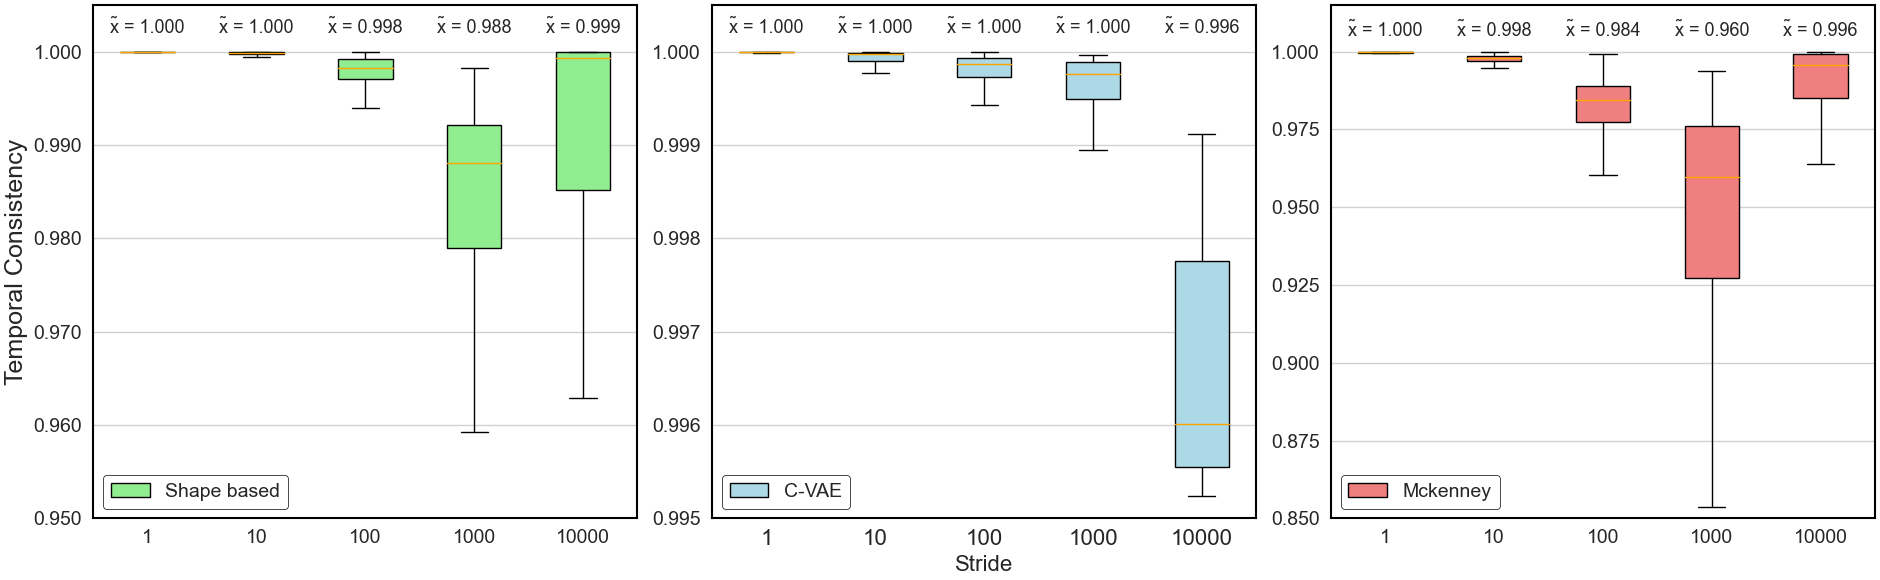

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# combine the data into a list and orders it according to the stride values
data_shp = [tc_shp_list_sp[0]['tc'], tc_shp_list_sp[1]['tc'], tc_shp_list_sp[2]['tc'], tc_shp_list_sp[3]['tc'], tc_shp_list_sp[4]['tc']]
data_cvae = [tc_cvae_list_sp[0]['tc'], tc_cvae_list_sp[1]['tc'], tc_cvae_list_sp[2]['tc'], tc_cvae_list_sp[3]['tc'], tc_cvae_list_sp[4]['tc']]
data_pstG = [tc_pstG_list_sp[0]['tc'], tc_pstG_list_sp[1]['tc'], tc_pstG_list_sp[2]['tc'], tc_pstG_list_sp[3]['tc'], tc_pstG_list_sp[4]['tc']]

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5

# Set up the figure and axes
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(19, 6))

# Create the first boxplot for data_shp
pos = [1, 2, 3, 4, 5]
boxplot1 = axs[0].boxplot(data_shp,
                        positions=pos,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=1),
                        patch_artist=True)

# # create anottation for median value for each boxplot
for i in range(len(pos)):
    axs[0].text(pos[i], 1.002, f"x̃ = {np.median(data_shp[i]):.3f}", horizontalalignment='center' ,fontsize=13)

# # TypeError: 'numpy.int32' object is not callable

# ax.annotate("?", 
#              xy=(0, 1), 
#              xytext=(3, 1.5),
#              arrowprops=dict(facecolor='black', shrink=0.05))

boxplot2 = axs[1].boxplot(data_cvae,
                        positions=pos,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=1),
                        patch_artist=True)

for i in range(len(pos)):
    axs[1].text(pos[i], 1.0002, f"x̃ = {np.median(data_cvae[i]):.3f}", horizontalalignment='center',fontsize=13)


boxplot3 = axs[2].boxplot(data_pstG,
                        positions=pos,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=1),
                        patch_artist=True)

for i in range(len(pos)):
    axs[2].text(pos[i], 1.005, f"x̃ = {np.median(data_pstG[i]):.3f}", horizontalalignment='center', fontsize=13)


ticks0 = np.arange(0.85, 1.01, 0.01)
axs[0].set_yticks(ticks0)
axs[0].grid(which='major', alpha=0.9, linewidth=1, axis='y')
axs[0].tick_params(labelsize=14)
axs[0].set_ylabel('Temporal Consistency', fontsize=18)
axs[0].set_ylim(0.95, 1.005)

# change the color of the boxplot
colors = ['lightgreen'] *5
for patch, color in zip(boxplot1['boxes'], colors):
    patch.set_facecolor(color)
    

# y axis decimal places for all subplots
from matplotlib.ticker import FormatStrFormatter
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
axs[2].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

ticks1 = np.arange(0.995, 1.001, 0.001)
axs[1].set_yticks(ticks1)
axs[1].grid(which='major', alpha=0.9, linewidth=1, axis='y')
axs[1].tick_params(labelsize=14)
axs[1].set_xticks(pos);
axs[1].set_xticklabels([ '1', '10', '100', '1000', '10000'], fontsize=16);
axs[1].set_xlabel('Stride', fontsize=16)
axs[1].set_ylim(0.995, 1.0005)

# change the color of the boxplot
colors = ['lightblue'] *5
for patch, color in zip(boxplot2['boxes'], colors):
    patch.set_facecolor(color)

ticks2 = np.arange(0.850, 1.002, 0.025)
axs[2].set_yticks(ticks2)

axs[2].grid(which='major', alpha=0.9, linewidth=1, axis='y')
axs[2].tick_params(labelsize=14)
axs[2].set_ylim(0.85, 1.015)
colors = ['lightcoral'] *5
for patch, color in zip(boxplot3['boxes'], colors):
    patch.set_facecolor(color)

# Add legend for each subplot. plot 1: shape based, plot 2: conditional VAE, plot 3: Pyspatiotemporalgeom
axs[0].legend([boxplot1["boxes"][0], boxplot1["boxes"][1], boxplot1["boxes"][2]],
['Shape based'],  fontsize=14, framealpha=1, frameon=True, facecolor='white', edgecolor='black', fancybox=True, loc='lower left')

axs[1].legend([boxplot2["boxes"][0], boxplot2["boxes"][1], boxplot2["boxes"][2]],
['C-VAE'],  fontsize=14, framealpha=1, frameon=True, facecolor='white', edgecolor='black', fancybox=True, loc='lower left')

axs[2].legend([boxplot3["boxes"][0], boxplot3["boxes"][1], boxplot3["boxes"][2]],
['Mckenney'],  fontsize=14, framealpha=1, frameon=True, facecolor='white', edgecolor='black', fancybox=True, loc='lower left')

    
# Add some space between the subplots and the bottom of the figure
fig.subplots_adjust(hspace=0.5, bottom=0.1)

axs[0].grid(False, axis='x')
axs[1].grid(False, axis='x')
axs[2].grid(False, axis='x')

plt.tight_layout()

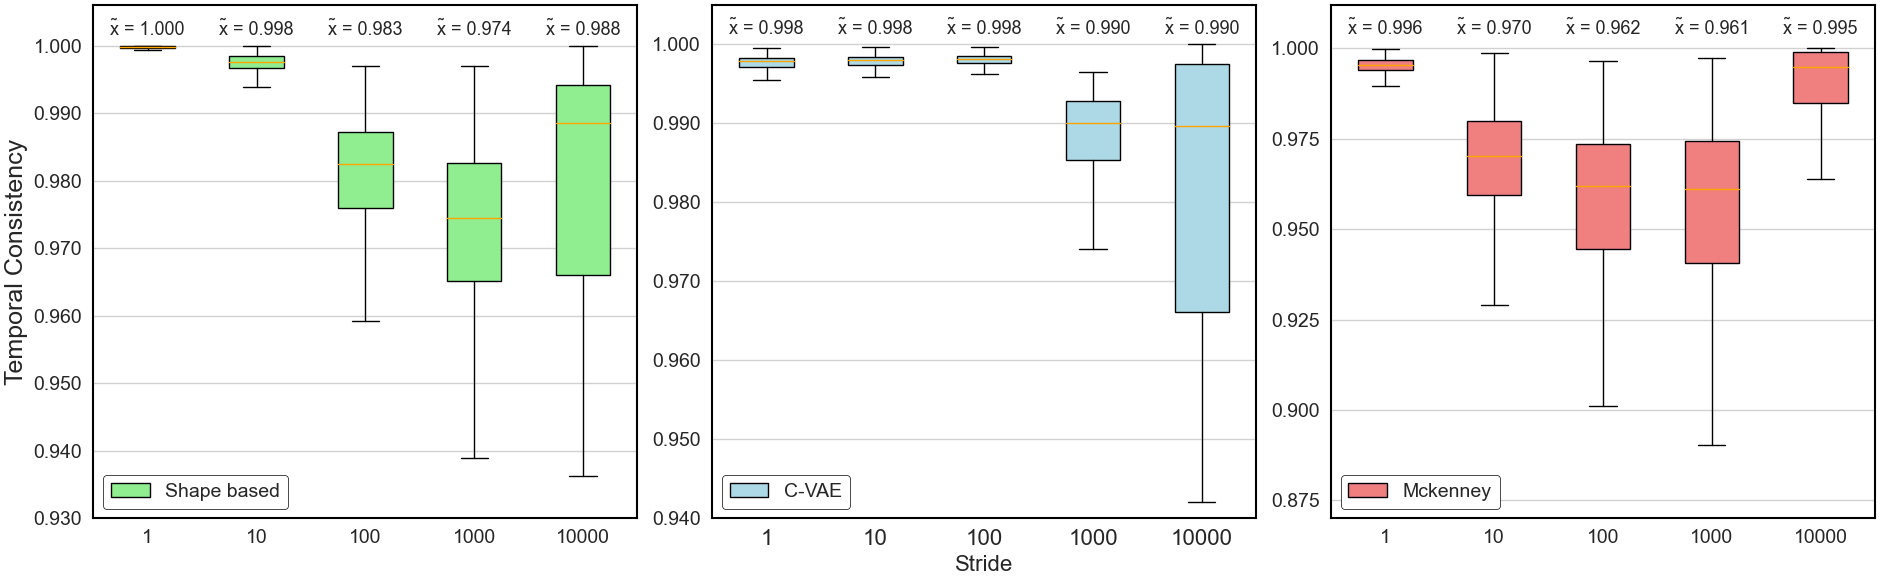

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# combine the data into a list and orders it according to the stride values
data_shp = [tc_shp_list[0]['tc'], tc_shp_list[1]['tc'], tc_shp_list[2]['tc'], tc_shp_list[3]['tc'], tc_shp_list[4]['tc']]
data_cvae = [tc_list[0]['tc'], tc_list[1]['tc'], tc_list[2]['tc'], tc_list[3]['tc'], tc_list[4]['tc']]
data_pstG = [tc_pstg_list[0]['tc'], tc_pstg_list[1]['tc'], tc_pstg_list[2]['tc'], tc_pstg_list[3]['tc'], tc_pstg_list[4]['tc']]

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5

# Set up the figure and axes
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(19, 6))

# Create the first boxplot for data_shp
pos = [1, 2, 3, 4, 5]
boxplot1 = axs[0].boxplot(data_shp,
                        positions=pos,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=1),
                        patch_artist=True)

# # create anottation for median value for each boxplot
for i in range(len(pos)):
    axs[0].text(pos[i], 1.0016, f"x̃ = {np.median(data_shp[i]):.3f}", horizontalalignment='center' ,fontsize=13)

# # TypeError: 'numpy.int32' object is not callable

# ax.annotate("?", 
#              xy=(0, 1), 
#              xytext=(3, 1.5),
#              arrowprops=dict(facecolor='black', shrink=0.05))

boxplot2 = axs[1].boxplot(data_cvae,
                        positions=pos,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=1),
                        patch_artist=True)

for i in range(len(pos)):
    axs[1].text(pos[i], 1.0013, f"x̃ = {np.median(data_cvae[i]):.3f}", horizontalalignment='center',fontsize=13)


boxplot3 = axs[2].boxplot(data_pstG,
                        positions=pos,
                        medianprops={'linewidth': 1, 'color': 'orange'},
                        showfliers=False,
                        flierprops=dict(markerfacecolor='r', markersize=1),
                        patch_artist=True)

for i in range(len(pos)):
    axs[2].text(pos[i], 1.004, f"x̃ = {np.median(data_pstG[i]):.3f}", horizontalalignment='center', fontsize=13)


ticks0 = np.arange(0.85, 1.01, 0.01)
axs[0].set_yticks(ticks0)
axs[0].grid(which='major', alpha=0.9, linewidth=1, axis='y')
axs[0].tick_params(labelsize=14)
axs[0].set_ylabel('Temporal Consistency', fontsize=18)
axs[0].set_ylim(0.93, 1.006)

# change the color of the boxplot
colors = ['lightgreen'] *5
for patch, color in zip(boxplot1['boxes'], colors):
    patch.set_facecolor(color)
    

# y axis decimal places for all subplots
from matplotlib.ticker import FormatStrFormatter
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
axs[2].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

ticks1 = np.arange(0.94, 1.001, 0.01)
axs[1].set_yticks(ticks1)
axs[1].grid(which='major', alpha=0.9, linewidth=1, axis='y')
axs[1].tick_params(labelsize=14)
axs[1].set_xticks(pos);
axs[1].set_xticklabels([ '1', '10', '100', '1000', '10000'], fontsize=16);
axs[1].set_xlabel('Stride', fontsize=16)
axs[1].set_ylim(0.94, 1.005)

# change the color of the boxplot
colors = ['lightblue'] *5
for patch, color in zip(boxplot2['boxes'], colors):
    patch.set_facecolor(color)

ticks2 = np.arange(0.850, 1.002, 0.025)
axs[2].set_yticks(ticks2)

axs[2].grid(which='major', alpha=0.9, linewidth=1, axis='y')
axs[2].tick_params(labelsize=14)
axs[2].set_ylim(0.87, 1.012)
colors = ['lightcoral'] *5
for patch, color in zip(boxplot3['boxes'], colors):
    patch.set_facecolor(color)

# Add legend for each subplot. plot 1: shape based, plot 2: conditional VAE, plot 3: Pyspatiotemporalgeom
axs[0].legend([boxplot1["boxes"][0], boxplot1["boxes"][1], boxplot1["boxes"][2]],
['Shape based'],  fontsize=14, framealpha=1, frameon=True, facecolor='white', edgecolor='black', fancybox=True, loc='lower left')

axs[1].legend([boxplot2["boxes"][0], boxplot2["boxes"][1], boxplot2["boxes"][2]],
['C-VAE'],  fontsize=14, framealpha=1, frameon=True, facecolor='white', edgecolor='black', fancybox=True, loc='lower left')

axs[2].legend([boxplot3["boxes"][0], boxplot3["boxes"][1], boxplot3["boxes"][2]],
['Mckenney'],  fontsize=14, framealpha=1, frameon=True, facecolor='white', edgecolor='black', fancybox=True, loc='lower left')

    
# Add some space between the subplots and the bottom of the figure
fig.subplots_adjust(hspace=0.5, bottom=0.1)

axs[0].grid(False, axis='x')
axs[1].grid(False, axis='x')
axs[2].grid(False, axis='x')

plt.tight_layout()

In [ ]:
# find minumum value in tc_pstG_list_sp and its index
pstg_min = min(tc_pstG_list_sp[4]["tc"]), tc_pstG_list_sp[4]["tc"].index(min(tc_pstG_list_sp[4]["tc"]))

# Pyspatiotemporalgeom
print("Reading WKTs file...")
with open(PSTG_WKT_FILE_SAMPLED, "r") as f:
    wkt_pstg = f.read().splitlines()

# delete lines with number = idx_sampled (one liner)
wkt_pstg = [item for i, item in enumerate(wkt_pstg) if i not in idx_sampled]
num_polygons = len(wkt_pstg)

# read WKTS file lines and convert to list of shapely polygons
polygons_pstg_sp = [loads(wkt) for wkt in wkt_pstg]
polygons_pstg_sp = polygons_pstg_sp[:num_polygons]


with open(CVAE_WKT_FILE_SAMPLED, "r") as f:
    wkt_cvae = f.read().splitlines()
# delete lines with number = idx_sampled (one liner)
wkt_cvae = [item for i, item in enumerate(wkt_cvae) if i not in idx_sampled]
num_polygons = len(wkt_cvae)

polygons_cvae_sp = [loads(wkt) for wkt in wkt_cvae]
polygons_cvae_sp = polygons_cvae_sp[:num_polygons]

with open(SHP_WKT_FILE_SAMPLED, "r") as f:
    wkt_shp = f.read().splitlines()
# delete lines with number = idx_sampled (one liner)
wkt_shp = [item for i, item in enumerate(wkt_shp) if i not in idx_sampled]
num_polygons = len(wkt_shp)

polygons_shp_sp = [loads(wkt_s) for wkt_s in wkt_shp]
polygons_shp_sp = polygons_shp_sp[:num_polygons]


Reading WKTs file...


In [ ]:
with open(PSTG_WKT_FILE, "r") as f:
    wkt_pstg = f.read().splitlines()
num_polygons = len(wkt_pstg)

polygons_pstg = [loads(wkt) for wkt in wkt_pstg]
polygons_pstg = polygons_pstg[:num_polygons]

with open(CVAE_WKT_FILE, "r") as f:
    wkt_cvae = f.read().splitlines()
num_polygons = len(wkt_cvae)

polygons_cvae = [loads(wkt) for wkt in wkt_cvae]
polygons_cvae = polygons_cvae[:num_polygons]

with open(SHP_WKT_FILE, "r") as f:
    wkt_shp = f.read().splitlines()
num_polygons = len(wkt_shp)

polygons_shp = [loads(wkt_s) for wkt_s in wkt_shp]
polygons_shp = polygons_shp[:num_polygons]

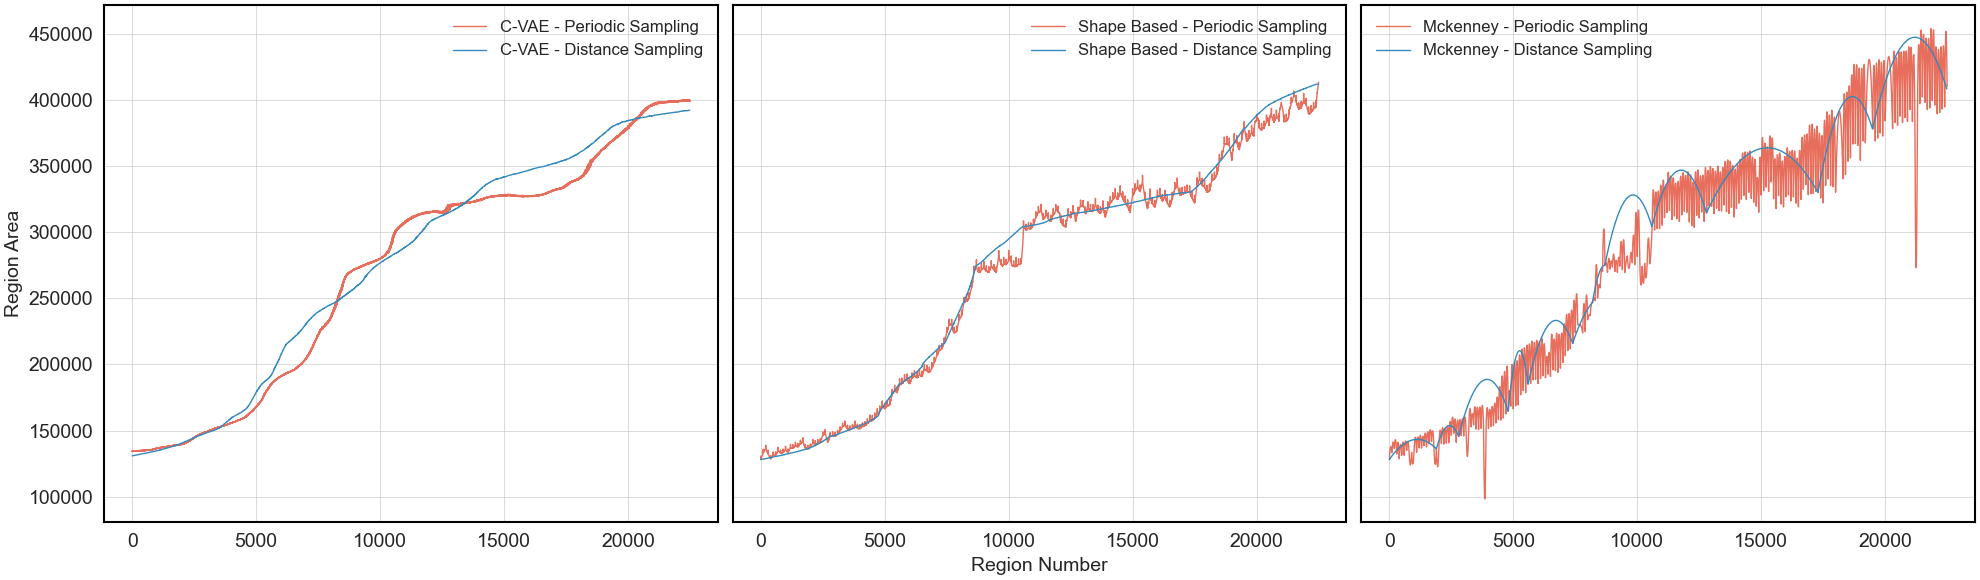

In [ ]:
# calculate area of list of polygons
area_pstg_sp = [polygons_pstg_sp[i].area for i in range(0, len(polygons_pstg_sp))]
area_cvae_sp = [polygons_cvae_sp[i].area for i in range(0, len(polygons_cvae_sp))]
area_shp_sp = [polygons_shp_sp[i].area for i in range(0, len(polygons_shp_sp))]
area_cvae = [polygons_cvae[i].area for i in range(0, len(polygons_cvae))]
area_pstg = [polygons_pstg[i].area for i in range(0, len(polygons_pstg))]
area_shp = [polygons_shp[i].area for i in range(0, len(polygons_shp))]

# 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# increase legend font size for all subplots
plt.rcParams['legend.fontsize'] = 12
# increase label font size for all subplots
plt.rcParams['axes.labelsize'] = 14

# plot area of list of polygons for each model
ax3.plot(area_pstg, label="Mckenney - Periodic Sampling", alpha=0.8)
ax3.plot(area_pstg_sp, label="Mckenney - Distance Sampling")

ax3.legend()
ax1.plot(area_cvae, label="C-VAE - Periodic Sampling", alpha=0.8)
ax1.plot(area_cvae_sp, label="C-VAE - Distance Sampling")

ax1.legend()
ax2.plot(area_shp, label="Shape Based - Periodic Sampling", alpha=0.8)
ax2.plot(area_shp_sp, label="Shape Based - Distance Sampling")
ax2.legend()

# y axis label
ax1.set_ylabel("Region Area")
# x axis label
ax2.set_xlabel("Region Number")

plt.tight_layout()

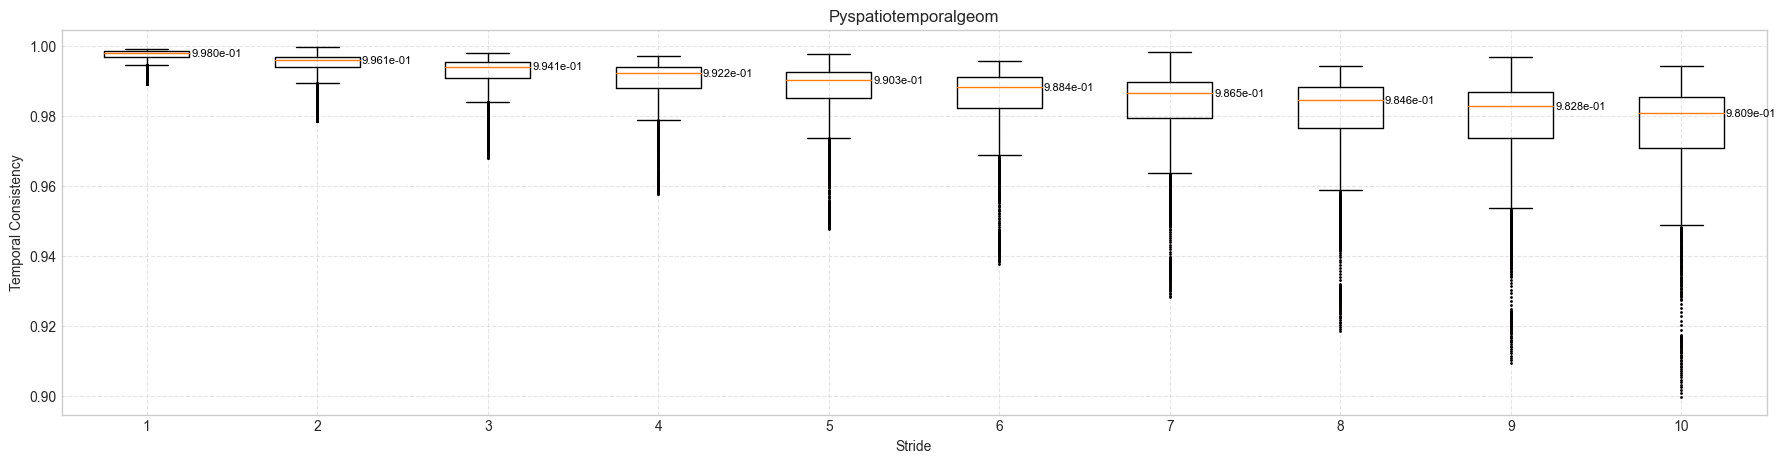

In [ ]:
# Pyspatiotemporalgeom boxplots in a single figure
fig, ax = plt.subplots(figsize=(22, 5))

ax.set_title('Pyspatiotemporalgeom')
ax.boxplot([tc_pstG_list[i]["tc"] for i in range(0, stride_rng)],
              flierprops=dict(markerfacecolor='r', markersize=1))
ax.set_xlabel("Stride")
ax.set_ylabel("Temporal Consistency")

# add annotations with the median value
for i in range(0, stride_rng):
    ax.annotate(f"{np.median(tc_pstG_list[i]['tc']):.3e}", (i+1, 
                np.median(tc_pstG_list[i]['tc'])), ha='left', va='center', 
                size=8, color='black', xytext=(32, 0), 
                textcoords='offset points')

ax.grid( linestyle="--", alpha=0.5)
plt.show()

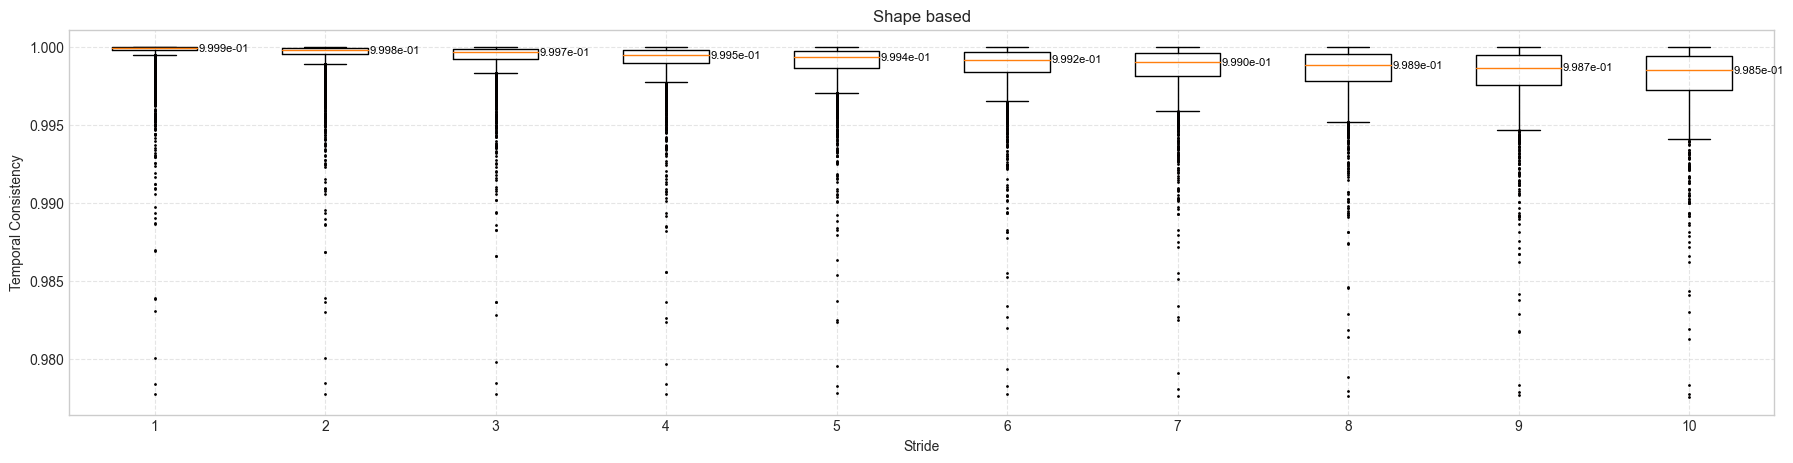

In [ ]:
# SHP boxplots in a single figure
fig, ax = plt.subplots(figsize=(22, 5))

ax.set_title('Shape based')
ax.boxplot([tc_shp_list[i]["tc"] for i in range(0, stride_rng)],
                flierprops=dict(markerfacecolor='r', markersize=1))
ax.set_xlabel("Stride")
ax.set_ylabel("Temporal Consistency")

# add annotations with the median value
for i in range(0, stride_rng):
    ax.annotate(f"{np.median(tc_shp_list[i]['tc']):.3e}", (i+1, 
                np.median(tc_shp_list[i]['tc'])), ha='left', va='center', 
                size=8, color='black', xytext=(32, 0), 
                textcoords='offset points')

ax.grid( linestyle="--", alpha=0.5)
plt.show()